# Simulation Methods Project

Adapted from Maciej Workiewicz

Authors:
* Pauline Engel
* Sebastian Erhardt
* Saskia Hasreiter
* Leo Schwarze
* Felix Siegel


In [17]:
import os
from time import time
import matplotlib.pyplot as plt
import random
import numpy as np
import itertools
import csv

In [18]:
AMOUNT_OF_ITERATIONS= 1000  # we will generate 1000 NK landscapes to begin with

## Interaction Matrix

In [19]:
def generate_random_interaction_matrix(N: int, K: int):
    '''
    This function takes the number of N elements and K interdependencies
    and creates a random N x N interaction matrix.
    All elements on the diagonal [0,0],[1,1],...[N-1,N-1] will be 1s.
    Based on the K, there will be additional K 1 in each row in addition to the diagonal.
    '''
    Int_matrix_rand = np.zeros((N, N)) # generate a N x N Matrix
    for aa1 in np.arange(N): # iterate over the indexes from 0,1,... to N
        Indexes_1 = list(range(N)) # generate a list from 0,1,... to N
        Indexes_1.remove(aa1)  # remove aa1 index e.g. remove 2 from the list
        np.random.shuffle(Indexes_1) # shuffle the indexes
        Indexes_1.append(aa1) # add the removed index again at the end
        Chosen_ones = Indexes_1[-(K+1):]  # extract the last K indexes in the shuffled 
        for aa2 in Chosen_ones: # iterate over the extracted indexes
            Int_matrix_rand[aa1, aa2] = 1  # set the poistion to 1 in the result matrix
    return(Int_matrix_rand)

## Calculate Coefficient

In [20]:
def calculate_coefficient(position, N:int, C:float):
    # sum of 1s in the position vector
    sum_of_ones = np.sum(position) 
    # get the max amount of the same values
    same_values = max(sum_of_ones, N-sum_of_ones)
    # calculate the coefficient
    coefficient = (1+((same_values/N)-0.5))**(same_values-(N/2))    
    # multiply the coefficient with the fitness factor
    result = coefficient * C    
    return result

In [21]:
calculate_coefficient(np.array([0,1,1,1,0,1]), 5, 0.1)

0.14822280526288795

In [22]:
calculate_coefficient(np.array([1,1,1,1,1,1]), 5, 0.1)

0.6405768283352122

In [23]:
calculate_coefficient(np.array([0,0,0,0,0,0]), 5, 0.1)

0.27556759606310754

In [24]:
calculate_coefficient(np.array([0,0,0,0,0,0]), 5, 0)

0.0

In [25]:
calculate_coefficient(np.array([0,0,0,0,0,0]), 5, 1)

2.7556759606310752

## Fitness Calculation

In [26]:
def calculate_fitness_vector(landscape, interaction_matrix, position, power_key, N, C):
    '''
    Takes the landscape, an interaction matrix and a given combination and returns a vector of fitness
    values for the vector of the N decision variables.
    ''' 
    # calculate the coefficient by providing the positionm, N and C
    coefficient = calculate_coefficient(position, N, C)
    # initialize the fitness vector with length N and 0
    result = np.zeros(N) 
    for y in np.arange(N):
        x = np.sum(position * interaction_matrix[y] * power_key)  
        # calculate the percieved fitness
        percieved_fitness = landscape[x, y] + coefficient      
        result[y] = percieved_fitness
    return(result)

## Calc Values for Landscapes

In [27]:
def generate_landscape(N:int, K:int, C:float, power_key):
    """
    Calculates values for all positions on the landscape. The resulting
    array contains:
    - the first columns indexed from 0 to N-1 are for each of the combinations
    - columns indexed from N to 2*N-1 are for the fit value (vector) of those combinations
    - the column indexed 2N is for the total fit (average of the entire vector)
    - column indexed 2N+1 is a dummy, with 1 indicating a local peak
    - the last column is a dummy, with 1 indicating the global peak
    """
    # generate a random interaction matrix
    interaction_matrix = generate_random_interaction_matrix(N, K).astype(int)
    # generate a random 2^N x N matrix
    # in every cell there is a random value between 0 and 1
    random_landscape = np.random.rand(2**N, N)  # this is a table of random U(0,1) numbers
    
    # inizialize a result matrix 
    # with the dimensions 2^N and N*2+3
    # the + 3 store the:
    # - the mean of the fitness vector
    # - if the position is a lokal peak
    # - if the position is a global peak
    result = np.zeros((2**N, N*2+3))  # to capture the results
    position_counter = 0  # starting counter for location
    
    # iterate over all possible representations of a list of the lenth of N
    # filled with 0s and 1s
    # starting with [0,0,0,0,..]
    # ending with [1,1,1,1,..]
    # so in the end there are 2^N combinations
    # imagine these combination as the position in the landscape
    for i in range(2**N):
        position = np.array(list(np.binary_repr(i).zfill(N))).astype(int) # taking each position
        
        # now calculate the fitness vector
        fit_1 = calculate_fitness_vector(random_landscape, interaction_matrix, position, power_key, N, C)
        
        result[position_counter, :N] = position  # store the position in the matrix
        result[position_counter, N:2*N] = fit_1
        result[position_counter, 2*N] = np.mean(fit_1)
        position_counter = position_counter + 1
    

    # look for the peaks    
    for c3 in np.arange(2**N):  # now let's see if it is a local peak
        loc_p = 1  # first, assume it is
        for c4 in np.arange(N):  # check the local neighbourhood
            new_comb = result[c3, :N].copy().astype(int)
            new_comb[c4] = abs(new_comb[c4] - 1)
            if ((result[c3, 2*N] <
                 result[np.sum(new_comb*power_key), 2*N])):
                loc_p = 0  # if smaller than the neighbour, then it is not peak
        result[c3, 2*N+1] = loc_p
    
    # store the global peak
    max_ind = np.argmax(result[:, 2*N]) # get the max result from the local peaks
    result[max_ind, 2*N+2] = 1 # set the global peak to 1
    return(result)

## Generate Landscapes

In [28]:
def generate_landscapes(N:int, K:int, C:float, power_key):
    # init empty landscapes tensor
    # Iterations
    # Landscape
    # Results
    landscapes = np.zeros((AMOUNT_OF_ITERATIONS, 2**N, N*2+3))  # we prepare an array to receive the data
    
    # iterate based on AMOUNT_OF_ITERATIONS
    # generate a landscape each time
    for iteration in np.arange(AMOUNT_OF_ITERATIONS):
        landscapes[iteration] = generate_landscape(N, K, C, power_key)
        
    return landscapes

## Statistics

In [29]:
def generate_title(N, K, C, p_jump):
    return f"N = {N}, K = {K}, C = {C}, p_jump = {p_jump}"

In [30]:
def print_statistics(landscapes, N, K, C, p_jump):    
    number_of_peaks = np.zeros(AMOUNT_OF_ITERATIONS)
    max_values = np.zeros(AMOUNT_OF_ITERATIONS)
    min_values = np.zeros(AMOUNT_OF_ITERATIONS)
    
    for i_2 in np.arange(AMOUNT_OF_ITERATIONS):
        number_of_peaks[i_2] = np.sum(landscapes[i_2, :, 2*N+1])
        max_values[i_2] = np.max(landscapes[i_2, :, 2*N])
        min_values[i_2] = np.min(landscapes[i_2, :, 2*N])
    
    # Let's print some summary statistics of our sample of NK landscapes
    print('Summary statistics')
    print(generate_title(N, K, C, p_jump))
    print('average number of peaks: ' + str(np.mean(number_of_peaks)))
    print('maximum number of peaks: ' + str(np.max(number_of_peaks)))
    print('minimum number of peaks: ' + str(np.min(number_of_peaks)))
    print('average maximum value: ' + str(np.mean(max_values)))
    print('average minimum value: ' + str(np.mean(min_values)))
    
    # plot histogram of the number of local peaks in our sample
    plt.hist(number_of_peaks, bins=20, range=(1, 20), color='dodgerblue') 
    plt.title('Distribution of the number of peaks \n' + generate_title(N, K, C, p_jump), size=12)
    plt.xlabel('number of peaks', size=10)
    plt.ylabel('frequency', size=10)
    plt.show()

## Search

In [31]:
def run_search(landscapes, N: int, K: int, C:float, p_jump:float, power_key):
  
    Output2 = np.zeros((AMOUNT_OF_ITERATIONS, t))
    
    for i1 in np.arange(AMOUNT_OF_ITERATIONS):
        combination = np.random.binomial(1, 0.5, N)  # gen initial combination
        row = np.sum(combination*power_key)  # finding the address in the array
        fitness = landscapes[i1, row, 2*N]  # piggyback on work done previously
        max_fit = np.max(landscapes[i1, :, 2*N])  # we will use it for normalization
        min_fit = np.min(landscapes[i1, :, 2*N])  # ditto
        fitness_norm = (fitness - min_fit)/(max_fit - min_fit)  # normalize 0 to 1
        
        # search
        for t1 in np.arange(t):  # time for local search
            Output2[i1, t1] = fitness_norm
            if np.random.rand() < p_jump:  # check whether we are doing a jump
                new_combination = np.random.binomial(1, 0.5, N)
            else:  # if not, then we simply search locally
                new_combination = combination.copy()
                choice_var = np.random.randint(N)
                new_combination[choice_var] = abs(new_combination[choice_var] - 1)
                
            row = np.sum(new_combination*power_key)
            new_fitness = landscapes[i1, row, 2*N]
            if new_fitness > fitness:  # if we have found a better combination
                combination = new_combination.copy()
                fitness = new_fitness.copy()
                fitness_norm = (fitness - min_fit)/(max_fit - min_fit)
            # otherwise all stays the same as in the previous round
    Fitness2 = np.mean(Output2, axis=0)
    final_fitness = Fitness2[t-1]
    # *** 3. PLOT ***************************************************************
    
    # We will do a simple plot of the average fitness value over t periods
    plt.figure(1, facecolor='white', figsize=(8, 6))
    plt.plot(Fitness2, color='green', linewidth=2, label='p_jump='+str(p_jump))
    plt.ylim(0.5, 1)
    plt.legend(loc=4,prop={'size':10})
    plt.title('Results of local search\n' + generate_title(N, K, C, p_jump), size=12)
    plt.xlabel('time periods', size=12)
    plt.ylabel('fitness', size=12)
    plt.show()
    print('Final fitness level for long jumps: ' + str(final_fitness))

    return final_fitness

# Experiments

In [32]:
t = 50  # time periods 

In [33]:
def run_experiment(N=5, K=3, C=0.0, p_jump=0):
    
    result = {
        "N": N,
        "K": K,
        "C": C,
        "p_jump": p_jump,
    }
    
    print(f"Run experiment with N = {N}, K = {K}, C = {C}, p_jump = {p_jump}")
    print("\n")
    # generate power key based on N
    power_key = np.power(2, np.arange(N - 1, -1, -1))  # used to find addresses on the landscape   
    
    # run experiment
    landscapes = generate_landscapes(N, K, C, power_key)
    print_statistics(landscapes, N, K, C, p_jump)
    final_fitness = run_search(landscapes, N, K, C, p_jump, power_key)
    
    # add final fitness to result
    result["final_fitness"] = final_fitness
    
    print("\n")
    print("#######################################################")
    print("\n\n\n")
    
    return result

## Run Experiments

In [34]:
Ns = [4,6]
Ks = [0,2,3,4]
Cs = [0,0.1,0.25,0.5,0.75,1]
p_jumps = [0.0,0.5,1]
results = []

Run experiment with N = 4, K = 0, C = 0, p_jump = 0.0


Summary statistics
N = 4, K = 0, C = 0, p_jump = 0.0
average number of peaks: 1.0
maximum number of peaks: 1.0
minimum number of peaks: 1.0
average maximum value: 0.6655768075294509
average minimum value: 0.3273586610863641


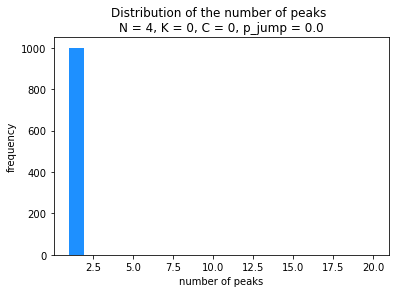

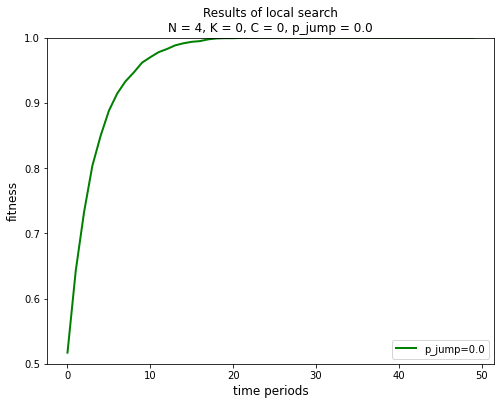

Final fitness level for long jumps: 1.0


#######################################################




Run experiment with N = 4, K = 0, C = 0, p_jump = 0.5


Summary statistics
N = 4, K = 0, C = 0, p_jump = 0.5
average number of peaks: 1.0
maximum number of peaks: 1.0
minimum number of peaks: 1.0
average maximum value: 0.662333594274013
average minimum value: 0.3280196704099838


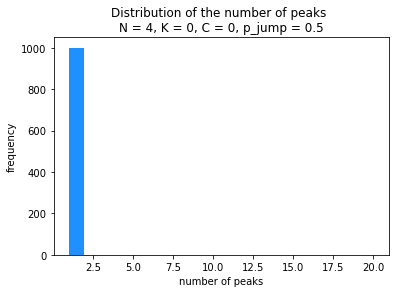

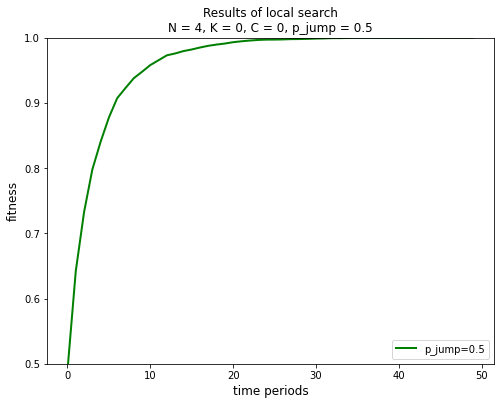

Final fitness level for long jumps: 1.0


#######################################################




Run experiment with N = 4, K = 0, C = 0, p_jump = 1


Summary statistics
N = 4, K = 0, C = 0, p_jump = 1
average number of peaks: 1.0
maximum number of peaks: 1.0
minimum number of peaks: 1.0
average maximum value: 0.6636272219141267
average minimum value: 0.3311605866215415


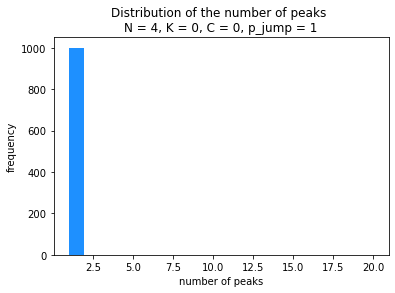

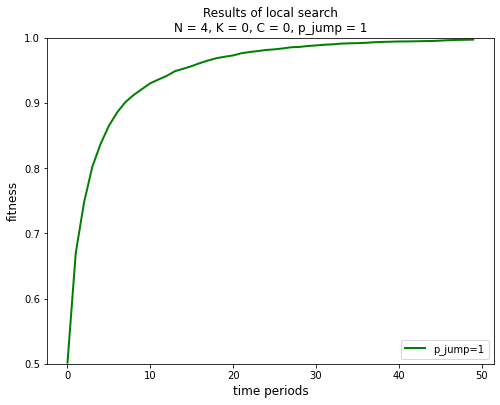

Final fitness level for long jumps: 0.9969711519619862


#######################################################




Run experiment with N = 4, K = 0, C = 0.1, p_jump = 0.0


Summary statistics
N = 4, K = 0, C = 0.1, p_jump = 0.0
average number of peaks: 1.397
maximum number of peaks: 3.0
minimum number of peaks: 1.0
average maximum value: 0.8187073922289242
average minimum value: 0.44873407568914775


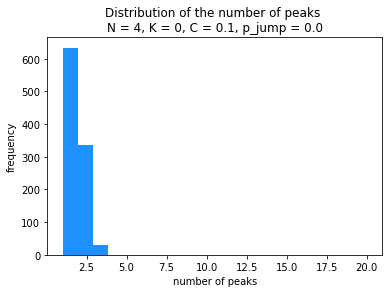

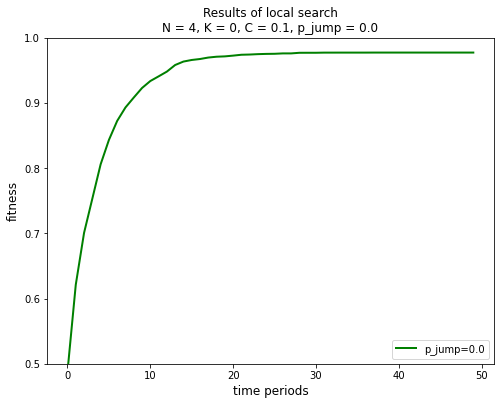

Final fitness level for long jumps: 0.9771203322162312


#######################################################




Run experiment with N = 4, K = 0, C = 0.1, p_jump = 0.5


Summary statistics
N = 4, K = 0, C = 0.1, p_jump = 0.5
average number of peaks: 1.383
maximum number of peaks: 3.0
minimum number of peaks: 1.0
average maximum value: 0.8188528577624079
average minimum value: 0.45028713310957696


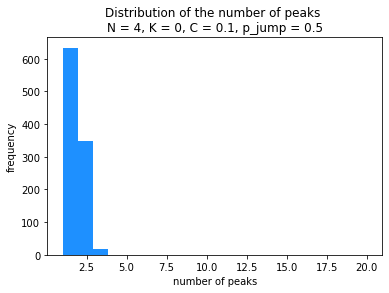

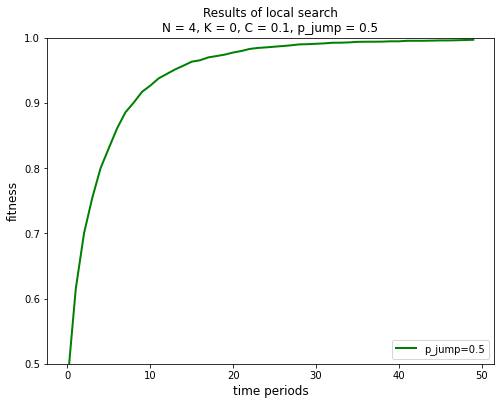

Final fitness level for long jumps: 0.9967230380466243


#######################################################




Run experiment with N = 4, K = 0, C = 0.1, p_jump = 1


Summary statistics
N = 4, K = 0, C = 0.1, p_jump = 1
average number of peaks: 1.353
maximum number of peaks: 3.0
minimum number of peaks: 1.0
average maximum value: 0.8272209362206779
average minimum value: 0.4499646927026538


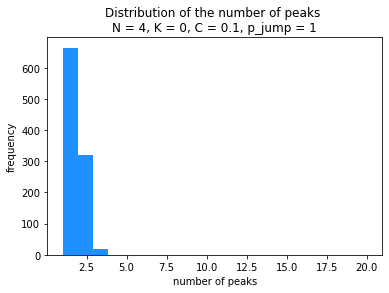

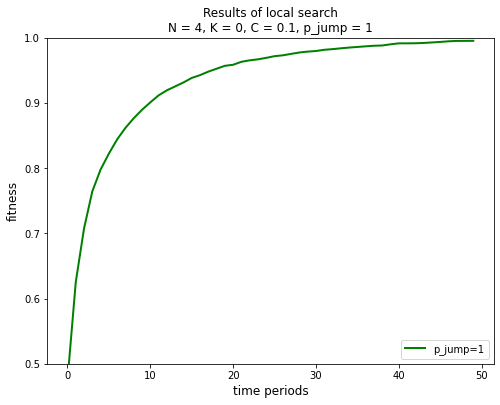

Final fitness level for long jumps: 0.9951275590492008


#######################################################




Run experiment with N = 4, K = 0, C = 0.25, p_jump = 0.0


Summary statistics
N = 4, K = 0, C = 0.25, p_jump = 0.0
average number of peaks: 2.041
maximum number of peaks: 3.0
minimum number of peaks: 2.0
average maximum value: 1.1426850527813253
average minimum value: 0.6061791023605422


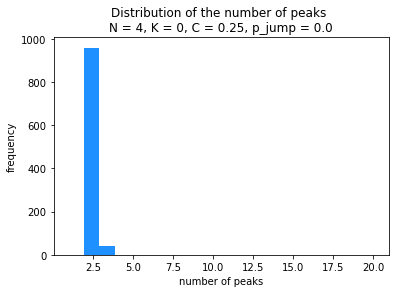

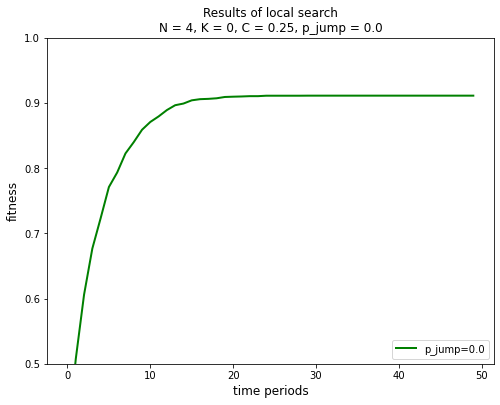

Final fitness level for long jumps: 0.9110662693121845


#######################################################




Run experiment with N = 4, K = 0, C = 0.25, p_jump = 0.5


Summary statistics
N = 4, K = 0, C = 0.25, p_jump = 0.5
average number of peaks: 2.034
maximum number of peaks: 3.0
minimum number of peaks: 2.0
average maximum value: 1.1482346440799656
average minimum value: 0.6106154550565616


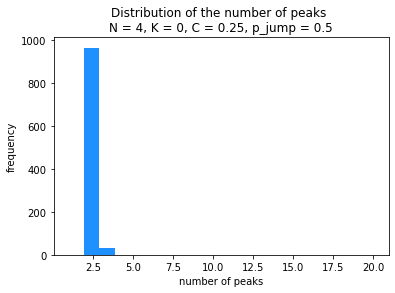

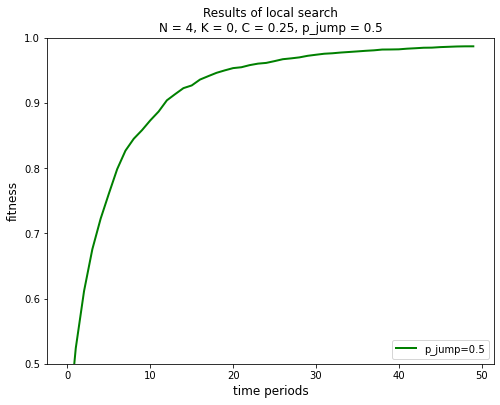

Final fitness level for long jumps: 0.9866965653782847


#######################################################




Run experiment with N = 4, K = 0, C = 0.25, p_jump = 1


Summary statistics
N = 4, K = 0, C = 0.25, p_jump = 1
average number of peaks: 2.042
maximum number of peaks: 3.0
minimum number of peaks: 2.0
average maximum value: 1.141048767843415
average minimum value: 0.6097623531439047


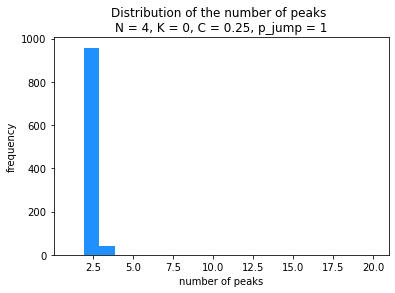

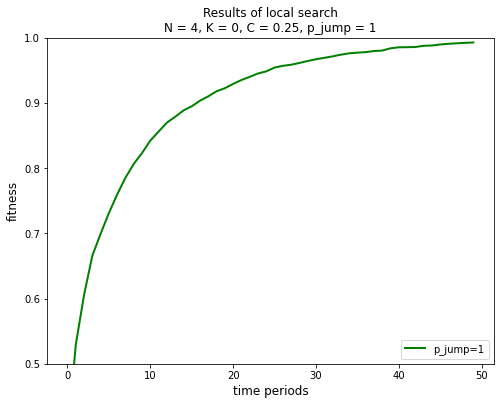

Final fitness level for long jumps: 0.9925526297607266


#######################################################




Run experiment with N = 4, K = 0, C = 0.5, p_jump = 0.0


Summary statistics
N = 4, K = 0, C = 0.5, p_jump = 0.0
average number of peaks: 2.002
maximum number of peaks: 3.0
minimum number of peaks: 2.0
average maximum value: 1.7076925471035256
average minimum value: 0.8655950535653737


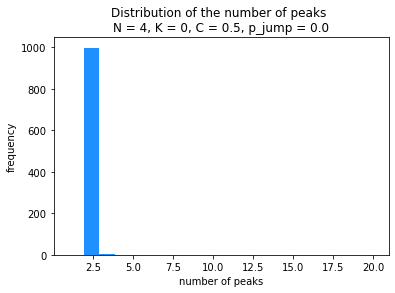

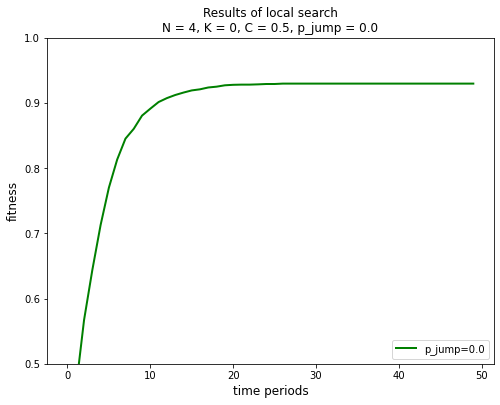

Final fitness level for long jumps: 0.9295351715827704


#######################################################




Run experiment with N = 4, K = 0, C = 0.5, p_jump = 0.5


Summary statistics
N = 4, K = 0, C = 0.5, p_jump = 0.5
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 1.7081590475926718
average minimum value: 0.863482690026265


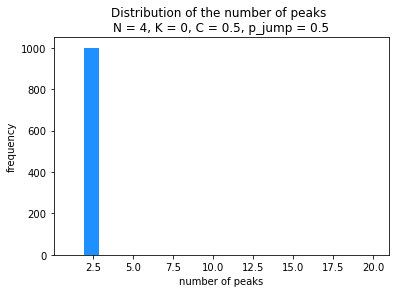

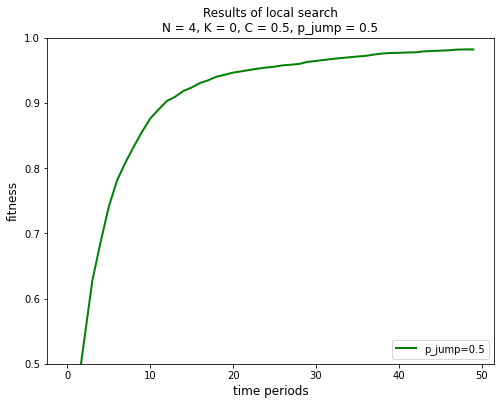

Final fitness level for long jumps: 0.9819457625134502


#######################################################




Run experiment with N = 4, K = 0, C = 0.5, p_jump = 1


Summary statistics
N = 4, K = 0, C = 0.5, p_jump = 1
average number of peaks: 2.001
maximum number of peaks: 3.0
minimum number of peaks: 2.0
average maximum value: 1.7049714255135255
average minimum value: 0.8608441841651276


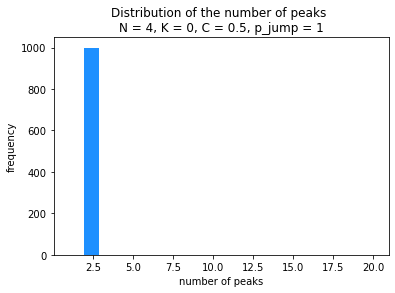

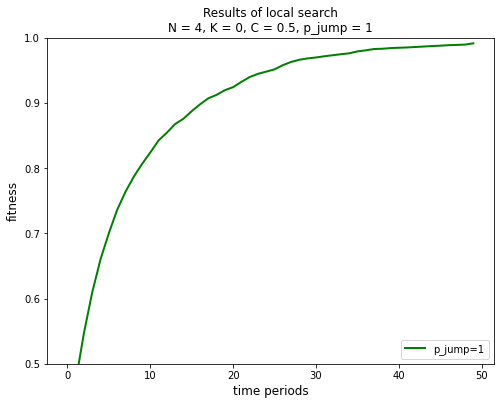

Final fitness level for long jumps: 0.9913191288749087


#######################################################




Run experiment with N = 4, K = 0, C = 0.75, p_jump = 0.0


Summary statistics
N = 4, K = 0, C = 0.75, p_jump = 0.0
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 2.265356450304389
average minimum value: 1.1094723138176892


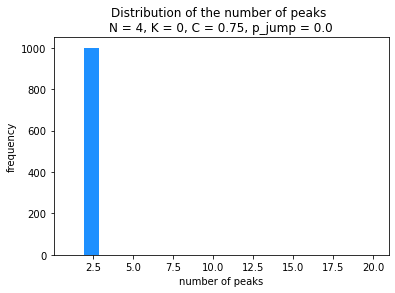

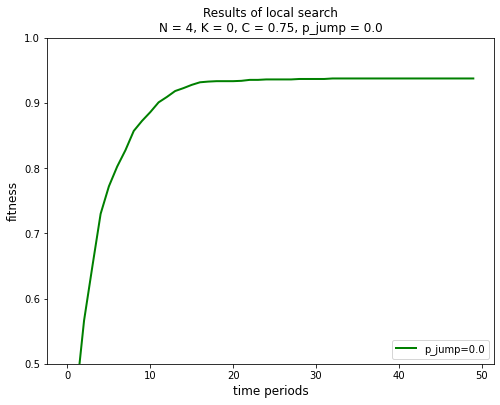

Final fitness level for long jumps: 0.9374102136871992


#######################################################




Run experiment with N = 4, K = 0, C = 0.75, p_jump = 0.5


Summary statistics
N = 4, K = 0, C = 0.75, p_jump = 0.5
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 2.2699944314272456
average minimum value: 1.112999061003155


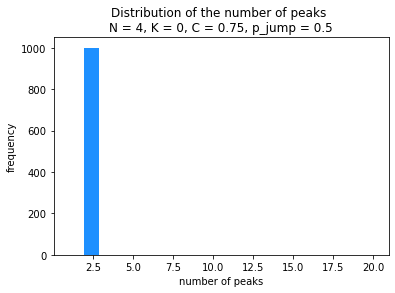

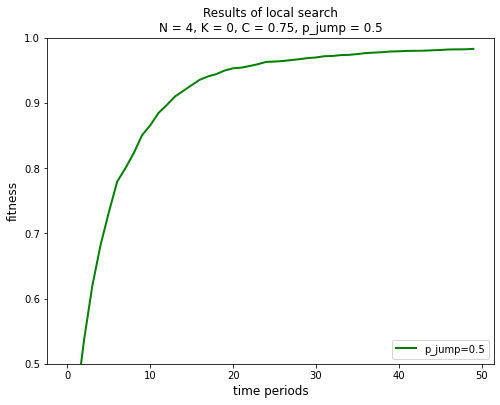

Final fitness level for long jumps: 0.9827331044082482


#######################################################




Run experiment with N = 4, K = 0, C = 0.75, p_jump = 1


Summary statistics
N = 4, K = 0, C = 0.75, p_jump = 1
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 2.265479033489108
average minimum value: 1.1073003915532926


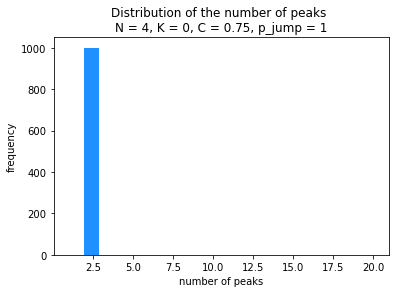

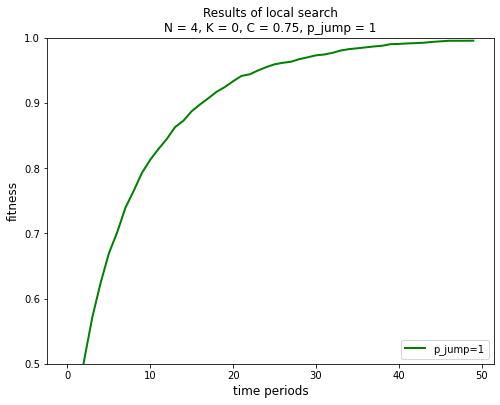

Final fitness level for long jumps: 0.9953330259464197


#######################################################




Run experiment with N = 4, K = 0, C = 1, p_jump = 0.0


Summary statistics
N = 4, K = 0, C = 1, p_jump = 0.0
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 2.829909584942826
average minimum value: 1.359777887219332


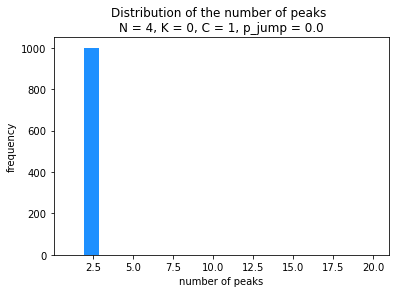

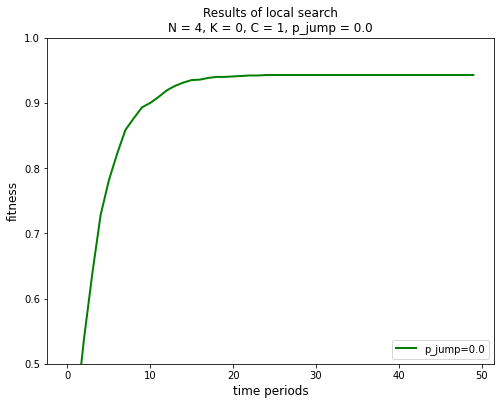

Final fitness level for long jumps: 0.9427098787140594


#######################################################




Run experiment with N = 4, K = 0, C = 1, p_jump = 0.5


Summary statistics
N = 4, K = 0, C = 1, p_jump = 0.5
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 2.830820657816047
average minimum value: 1.359905095485947


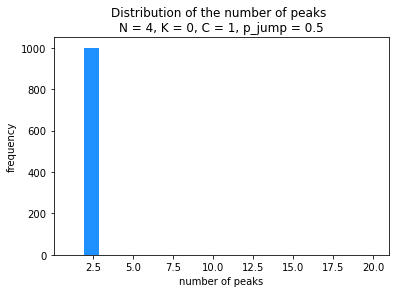

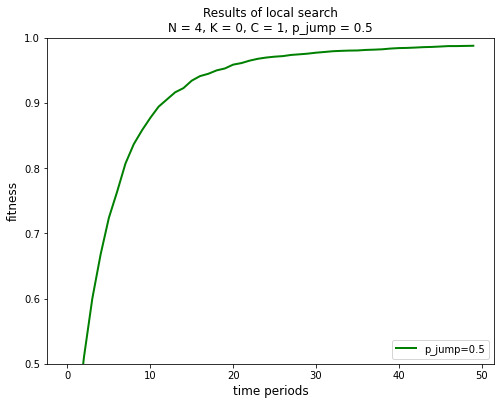

Final fitness level for long jumps: 0.9875415088099198


#######################################################




Run experiment with N = 4, K = 0, C = 1, p_jump = 1


Summary statistics
N = 4, K = 0, C = 1, p_jump = 1
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 2.8306928274148815
average minimum value: 1.3605845143582314


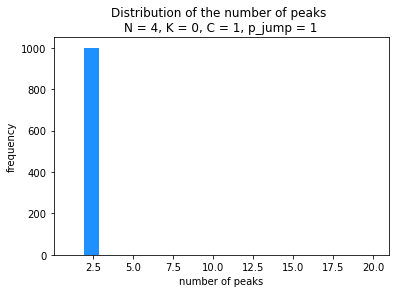

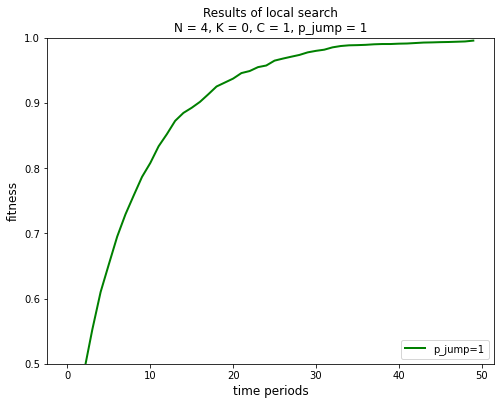

Final fitness level for long jumps: 0.9954466816443253


#######################################################




Run experiment with N = 4, K = 2, C = 0, p_jump = 0.0


Summary statistics
N = 4, K = 2, C = 0, p_jump = 0.0
average number of peaks: 2.354
maximum number of peaks: 4.0
minimum number of peaks: 1.0
average maximum value: 0.7378385707792385
average minimum value: 0.2628602806422616


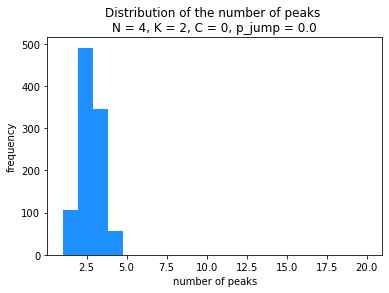

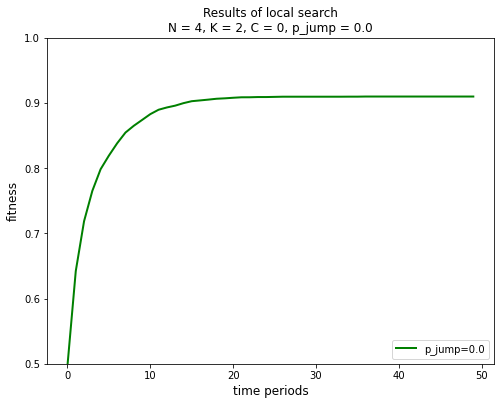

Final fitness level for long jumps: 0.909717106856771


#######################################################




Run experiment with N = 4, K = 2, C = 0, p_jump = 0.5


Summary statistics
N = 4, K = 2, C = 0, p_jump = 0.5
average number of peaks: 2.406
maximum number of peaks: 4.0
minimum number of peaks: 1.0
average maximum value: 0.7367310154033595
average minimum value: 0.2592126502274798


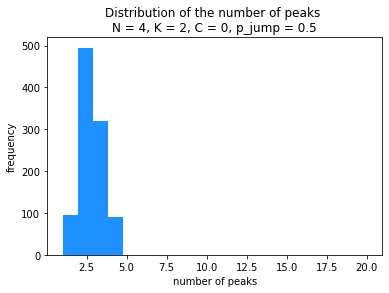

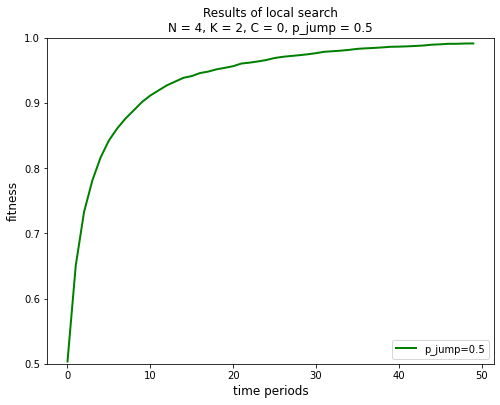

Final fitness level for long jumps: 0.9911181188459803


#######################################################




Run experiment with N = 4, K = 2, C = 0, p_jump = 1


Summary statistics
N = 4, K = 2, C = 0, p_jump = 1
average number of peaks: 2.367
maximum number of peaks: 5.0
minimum number of peaks: 1.0
average maximum value: 0.7323882489420851
average minimum value: 0.25932280295605553


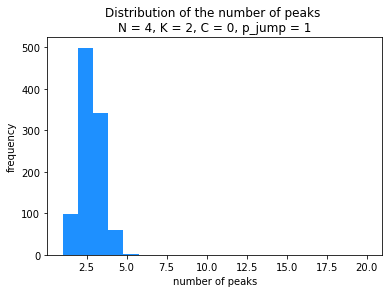

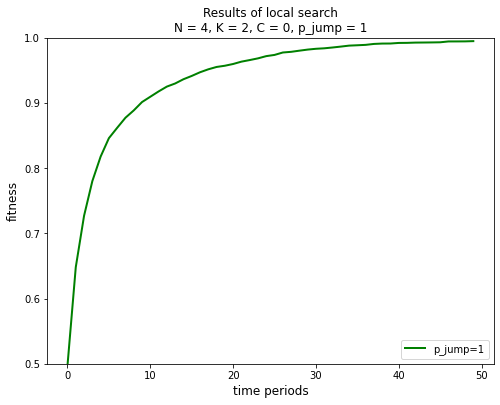

Final fitness level for long jumps: 0.994643893722761


#######################################################




Run experiment with N = 4, K = 2, C = 0.1, p_jump = 0.0


Summary statistics
N = 4, K = 2, C = 0.1, p_jump = 0.0
average number of peaks: 2.358
maximum number of peaks: 4.0
minimum number of peaks: 1.0
average maximum value: 0.8814953957918062
average minimum value: 0.3818422135254368


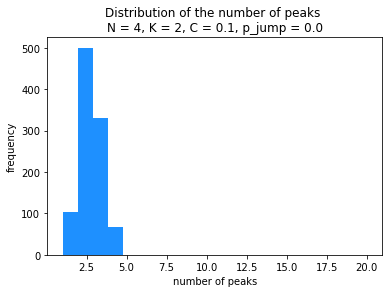

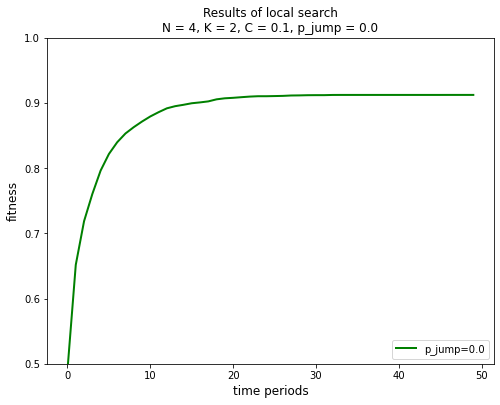

Final fitness level for long jumps: 0.9122038046149336


#######################################################




Run experiment with N = 4, K = 2, C = 0.1, p_jump = 0.5


Summary statistics
N = 4, K = 2, C = 0.1, p_jump = 0.5
average number of peaks: 2.367
maximum number of peaks: 4.0
minimum number of peaks: 1.0
average maximum value: 0.8829421613993356
average minimum value: 0.3791225208613719


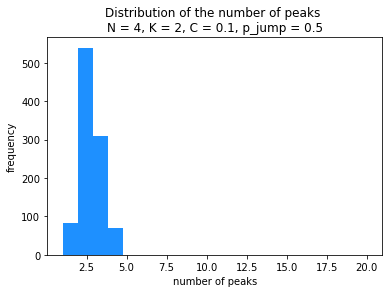

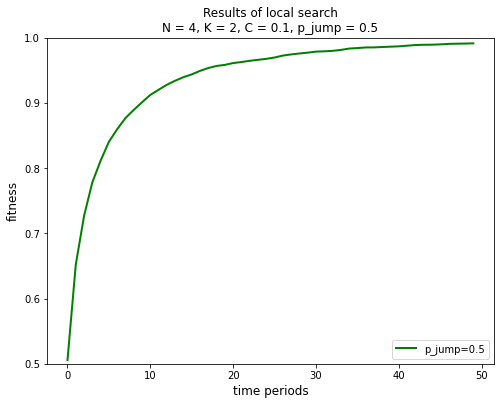

Final fitness level for long jumps: 0.9912538568145172


#######################################################




Run experiment with N = 4, K = 2, C = 0.1, p_jump = 1


Summary statistics
N = 4, K = 2, C = 0.1, p_jump = 1
average number of peaks: 2.432
maximum number of peaks: 5.0
minimum number of peaks: 1.0
average maximum value: 0.880889076240047
average minimum value: 0.38177806985212065


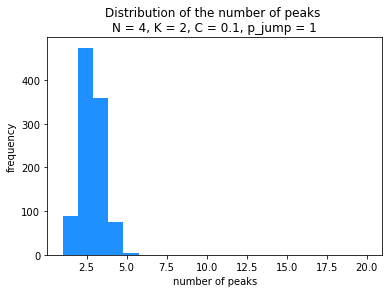

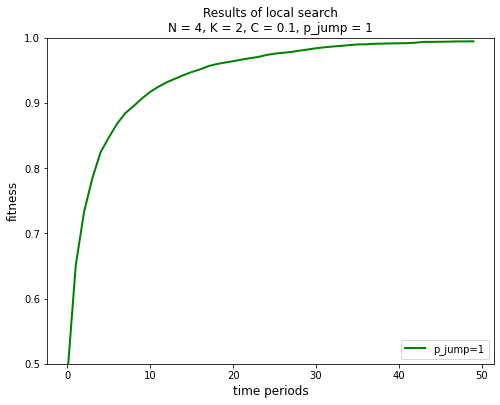

Final fitness level for long jumps: 0.9943604045833492


#######################################################




Run experiment with N = 4, K = 2, C = 0.25, p_jump = 0.0


Summary statistics
N = 4, K = 2, C = 0.25, p_jump = 0.0
average number of peaks: 2.343
maximum number of peaks: 5.0
minimum number of peaks: 1.0
average maximum value: 1.1586788345059273
average minimum value: 0.5473819673706043


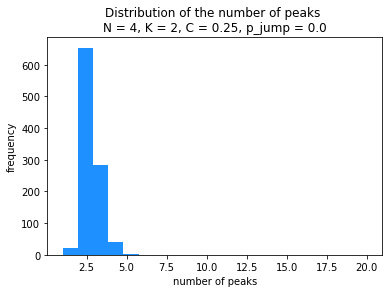

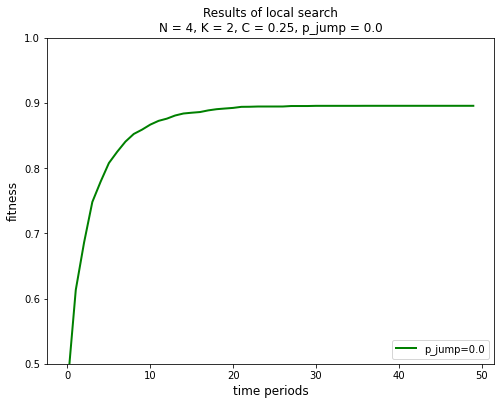

Final fitness level for long jumps: 0.8955076773546751


#######################################################




Run experiment with N = 4, K = 2, C = 0.25, p_jump = 0.5


Summary statistics
N = 4, K = 2, C = 0.25, p_jump = 0.5
average number of peaks: 2.313
maximum number of peaks: 4.0
minimum number of peaks: 1.0
average maximum value: 1.1535070846317919
average minimum value: 0.5491464965655016


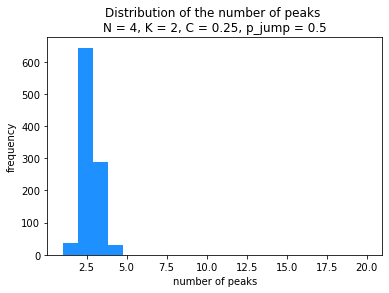

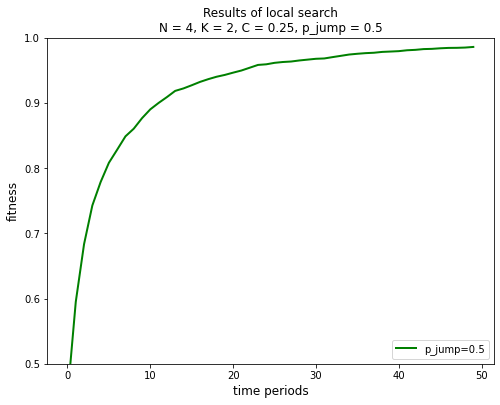

Final fitness level for long jumps: 0.9857473208163904


#######################################################




Run experiment with N = 4, K = 2, C = 0.25, p_jump = 1


Summary statistics
N = 4, K = 2, C = 0.25, p_jump = 1
average number of peaks: 2.317
maximum number of peaks: 4.0
minimum number of peaks: 1.0
average maximum value: 1.1572777818579203
average minimum value: 0.5452169633502708


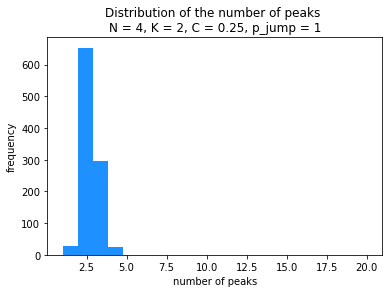

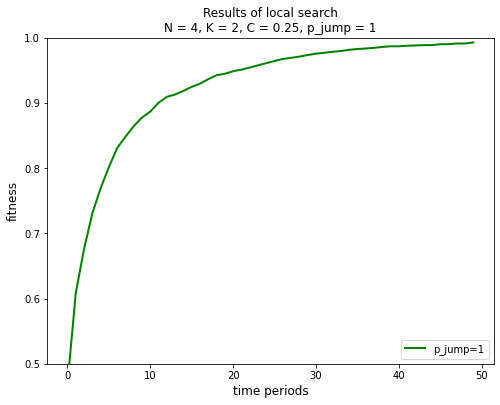

Final fitness level for long jumps: 0.9926138835462037


#######################################################




Run experiment with N = 4, K = 2, C = 0.5, p_jump = 0.0


Summary statistics
N = 4, K = 2, C = 0.5, p_jump = 0.0
average number of peaks: 2.112
maximum number of peaks: 4.0
minimum number of peaks: 2.0
average maximum value: 1.7133233589530048
average minimum value: 0.8117089502057371


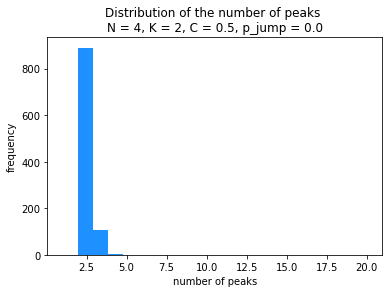

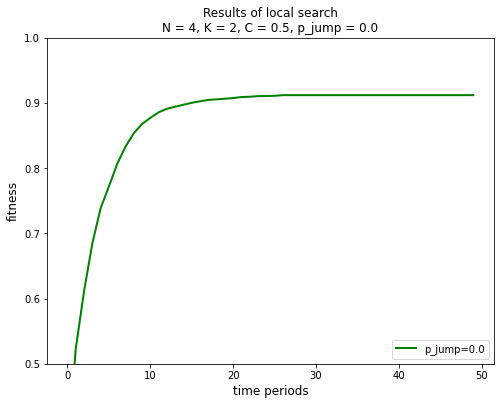

Final fitness level for long jumps: 0.9118464239040024


#######################################################




Run experiment with N = 4, K = 2, C = 0.5, p_jump = 0.5


Summary statistics
N = 4, K = 2, C = 0.5, p_jump = 0.5
average number of peaks: 2.135
maximum number of peaks: 4.0
minimum number of peaks: 2.0
average maximum value: 1.7055044933838768
average minimum value: 0.8124008940853272


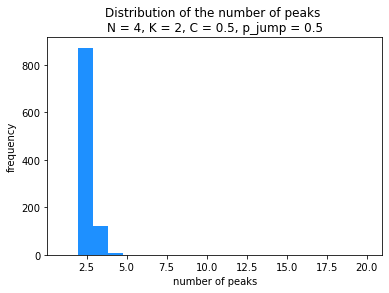

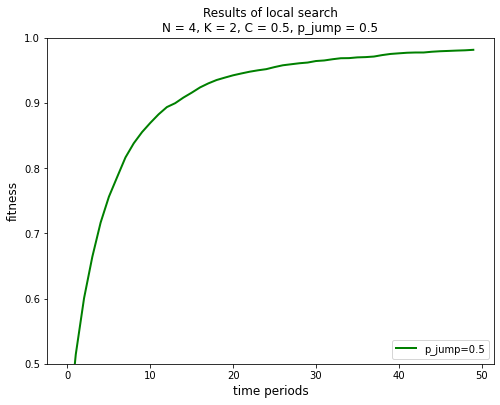

Final fitness level for long jumps: 0.9813391935225032


#######################################################




Run experiment with N = 4, K = 2, C = 0.5, p_jump = 1


Summary statistics
N = 4, K = 2, C = 0.5, p_jump = 1
average number of peaks: 2.123
maximum number of peaks: 4.0
minimum number of peaks: 2.0
average maximum value: 1.7080825280895682
average minimum value: 0.8116286169993034


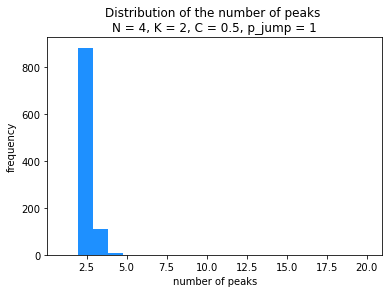

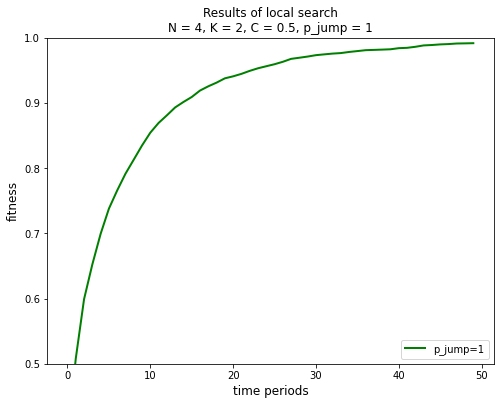

Final fitness level for long jumps: 0.9914905662376283


#######################################################




Run experiment with N = 4, K = 2, C = 0.75, p_jump = 0.0


Summary statistics
N = 4, K = 2, C = 0.75, p_jump = 0.0
average number of peaks: 2.035
maximum number of peaks: 3.0
minimum number of peaks: 2.0
average maximum value: 2.270813550626908
average minimum value: 1.0629225300811431


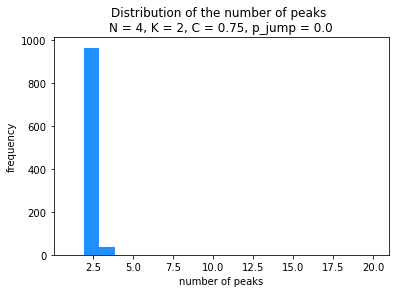

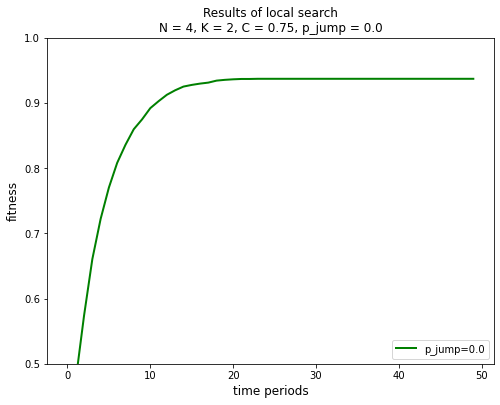

Final fitness level for long jumps: 0.9369071085054845


#######################################################




Run experiment with N = 4, K = 2, C = 0.75, p_jump = 0.5


Summary statistics
N = 4, K = 2, C = 0.75, p_jump = 0.5
average number of peaks: 2.03
maximum number of peaks: 3.0
minimum number of peaks: 2.0
average maximum value: 2.2713921973729168
average minimum value: 1.066732723253115


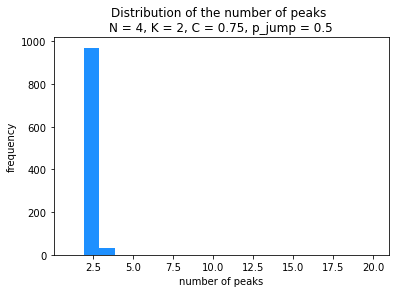

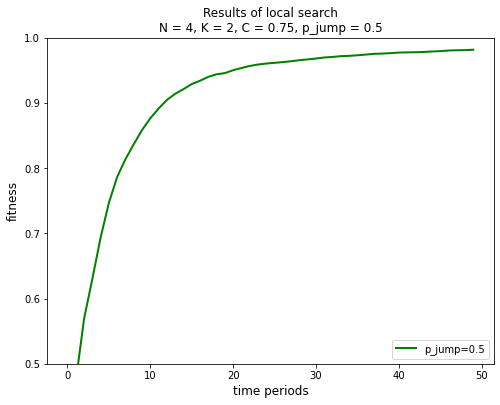

Final fitness level for long jumps: 0.9814901723062275


#######################################################




Run experiment with N = 4, K = 2, C = 0.75, p_jump = 1


Summary statistics
N = 4, K = 2, C = 0.75, p_jump = 1
average number of peaks: 2.029
maximum number of peaks: 4.0
minimum number of peaks: 2.0
average maximum value: 2.273344621899383
average minimum value: 1.0716438065836975


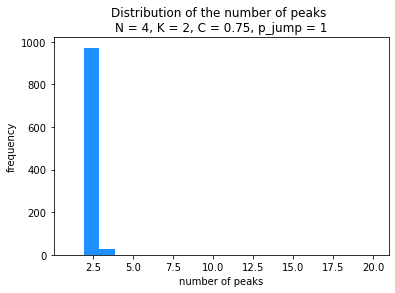

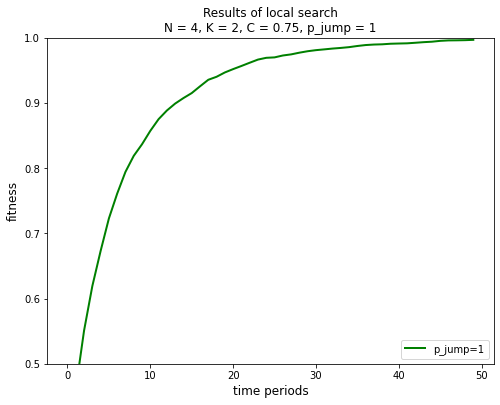

Final fitness level for long jumps: 0.9966258045678023


#######################################################




Run experiment with N = 4, K = 2, C = 1, p_jump = 0.0


Summary statistics
N = 4, K = 2, C = 1, p_jump = 0.0
average number of peaks: 2.004
maximum number of peaks: 3.0
minimum number of peaks: 2.0
average maximum value: 2.83310414680706
average minimum value: 1.3175912537694683


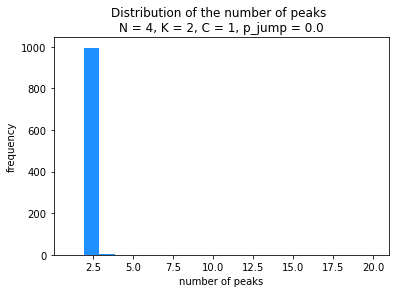

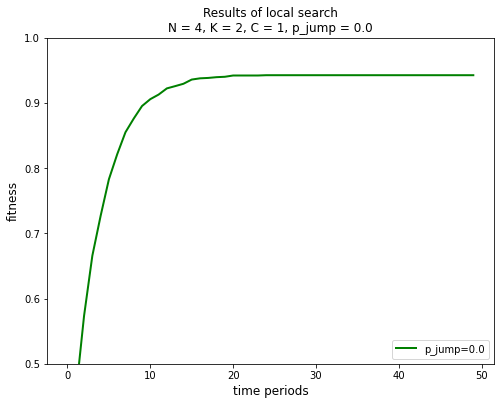

Final fitness level for long jumps: 0.9424194005755623


#######################################################




Run experiment with N = 4, K = 2, C = 1, p_jump = 0.5


Summary statistics
N = 4, K = 2, C = 1, p_jump = 0.5
average number of peaks: 2.012
maximum number of peaks: 3.0
minimum number of peaks: 2.0
average maximum value: 2.8351600521365152
average minimum value: 1.3227105272069357


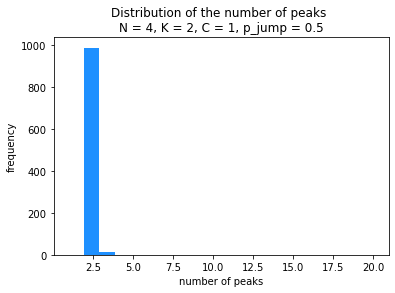

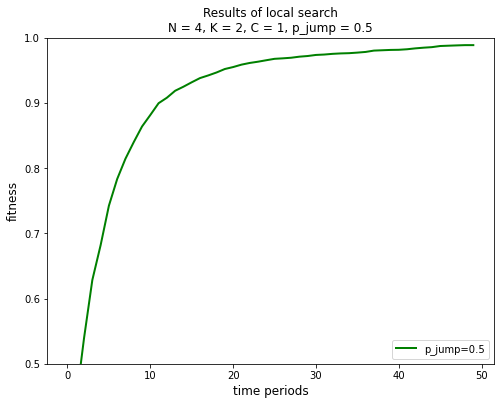

Final fitness level for long jumps: 0.988516894363088


#######################################################




Run experiment with N = 4, K = 2, C = 1, p_jump = 1


Summary statistics
N = 4, K = 2, C = 1, p_jump = 1
average number of peaks: 2.007
maximum number of peaks: 3.0
minimum number of peaks: 2.0
average maximum value: 2.834812324804717
average minimum value: 1.3156764497053228


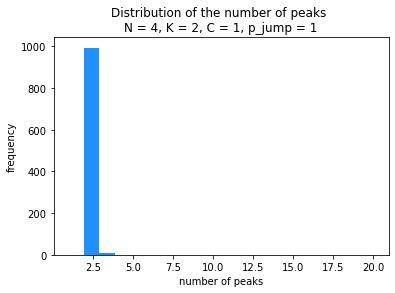

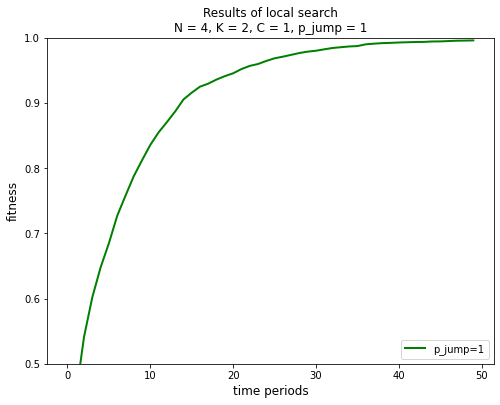

Final fitness level for long jumps: 0.9957725524827894


#######################################################




Run experiment with N = 4, K = 3, C = 0, p_jump = 0.0


Summary statistics
N = 4, K = 3, C = 0, p_jump = 0.0
average number of peaks: 3.188
maximum number of peaks: 7.0
minimum number of peaks: 1.0
average maximum value: 0.7489938283443869
average minimum value: 0.24659819818543907


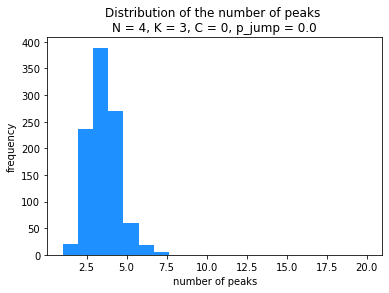

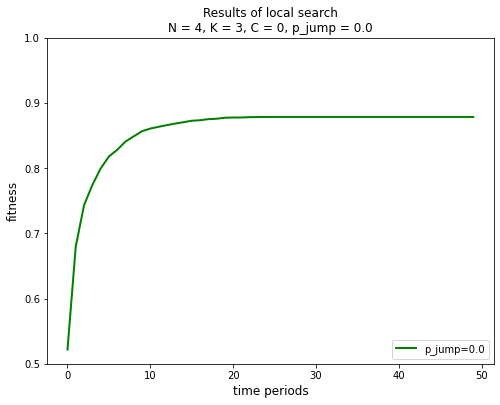

Final fitness level for long jumps: 0.8783981244854566


#######################################################




Run experiment with N = 4, K = 3, C = 0, p_jump = 0.5


Summary statistics
N = 4, K = 3, C = 0, p_jump = 0.5
average number of peaks: 3.208
maximum number of peaks: 8.0
minimum number of peaks: 1.0
average maximum value: 0.7483475721344782
average minimum value: 0.2450351504894761


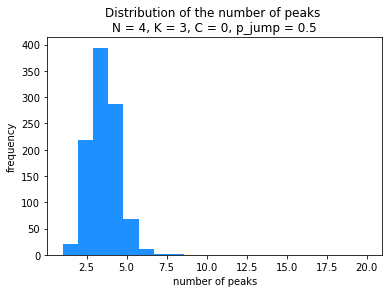

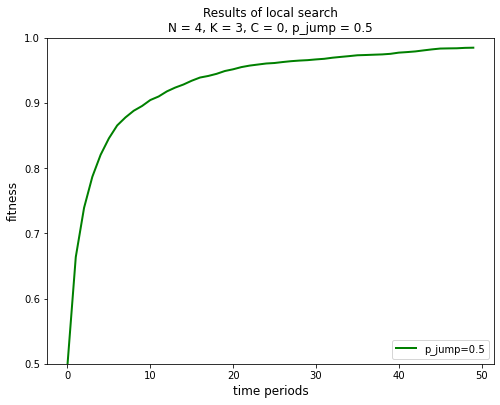

Final fitness level for long jumps: 0.9845833592953439


#######################################################




Run experiment with N = 4, K = 3, C = 0, p_jump = 1


Summary statistics
N = 4, K = 3, C = 0, p_jump = 1
average number of peaks: 3.165
maximum number of peaks: 8.0
minimum number of peaks: 1.0
average maximum value: 0.7518190457276512
average minimum value: 0.2491323155688401


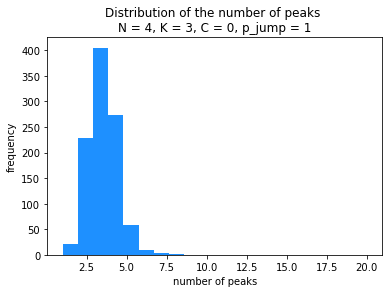

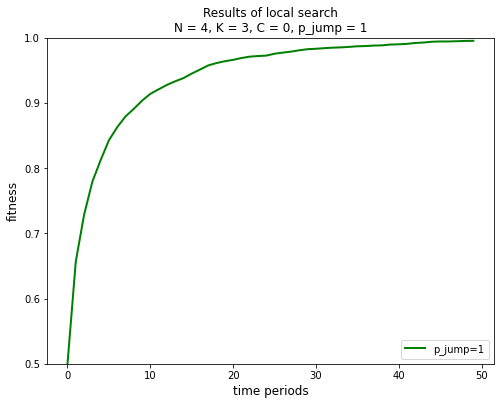

Final fitness level for long jumps: 0.9951243312715814


#######################################################




Run experiment with N = 4, K = 3, C = 0.1, p_jump = 0.0


Summary statistics
N = 4, K = 3, C = 0.1, p_jump = 0.0
average number of peaks: 3.169
maximum number of peaks: 7.0
minimum number of peaks: 1.0
average maximum value: 0.893492461665226
average minimum value: 0.3667057724161045


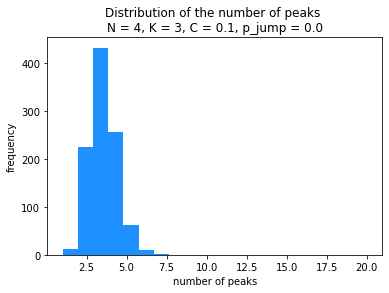

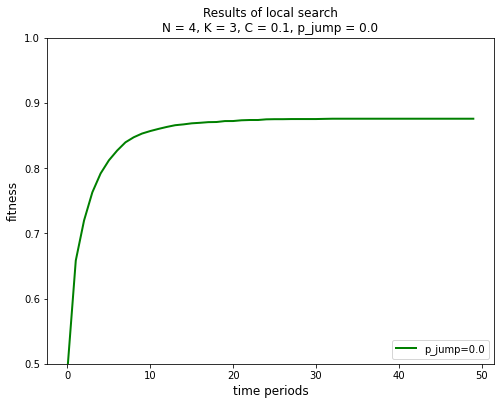

Final fitness level for long jumps: 0.8757097440537682


#######################################################




Run experiment with N = 4, K = 3, C = 0.1, p_jump = 0.5


Summary statistics
N = 4, K = 3, C = 0.1, p_jump = 0.5
average number of peaks: 3.186
maximum number of peaks: 7.0
minimum number of peaks: 1.0
average maximum value: 0.8885450810412259
average minimum value: 0.3696952469280498


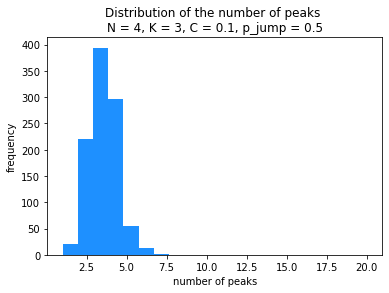

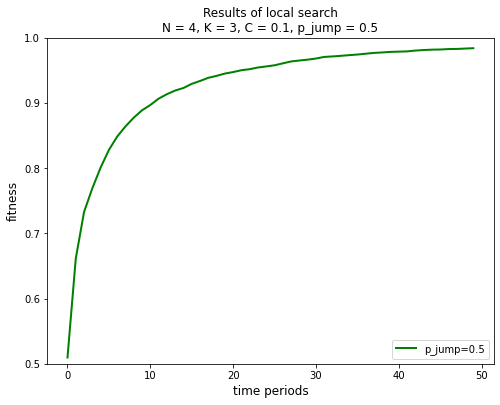

Final fitness level for long jumps: 0.9837988001706266


#######################################################




Run experiment with N = 4, K = 3, C = 0.1, p_jump = 1


Summary statistics
N = 4, K = 3, C = 0.1, p_jump = 1
average number of peaks: 3.102
maximum number of peaks: 8.0
minimum number of peaks: 1.0
average maximum value: 0.8868055439120351
average minimum value: 0.3675769997661811


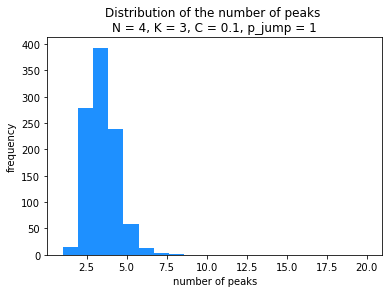

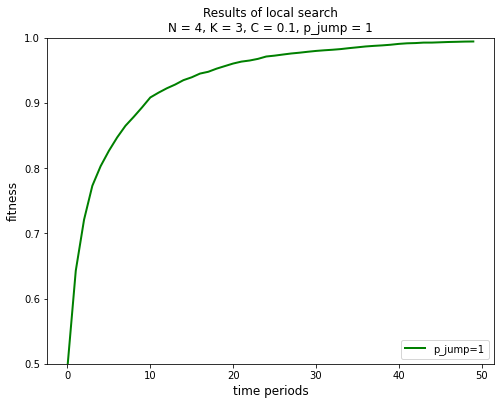

Final fitness level for long jumps: 0.9940993277114338


#######################################################




Run experiment with N = 4, K = 3, C = 0.25, p_jump = 0.0


Summary statistics
N = 4, K = 3, C = 0.25, p_jump = 0.0
average number of peaks: 2.825
maximum number of peaks: 6.0
minimum number of peaks: 1.0
average maximum value: 1.1602724019964257
average minimum value: 0.5364151145560171


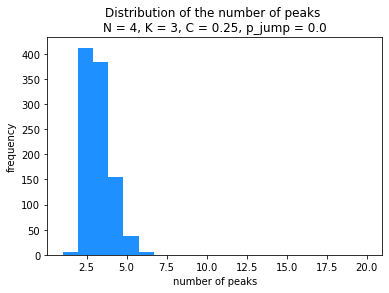

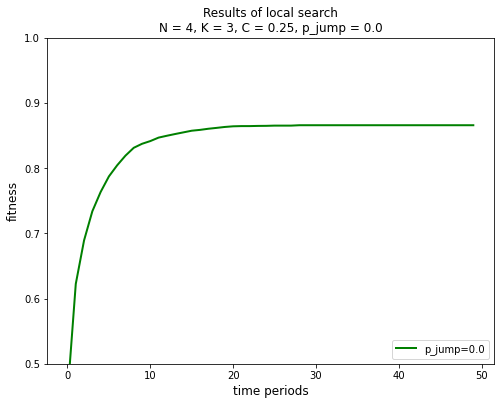

Final fitness level for long jumps: 0.8657365216372361


#######################################################




Run experiment with N = 4, K = 3, C = 0.25, p_jump = 0.5


Summary statistics
N = 4, K = 3, C = 0.25, p_jump = 0.5
average number of peaks: 2.797
maximum number of peaks: 8.0
minimum number of peaks: 1.0
average maximum value: 1.158351802299484
average minimum value: 0.5384187611764899


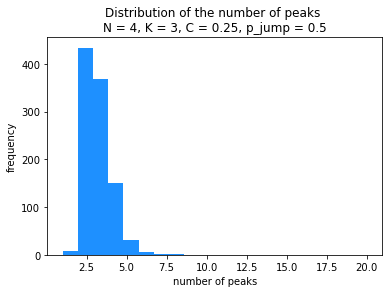

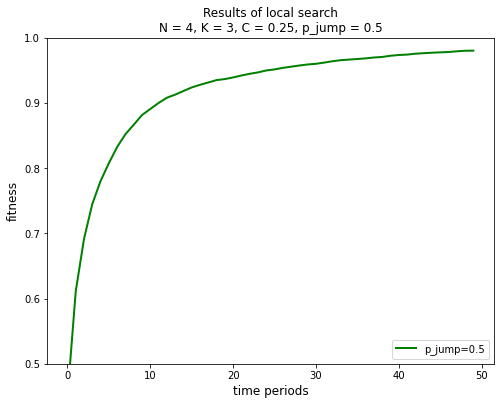

Final fitness level for long jumps: 0.9800939964527118


#######################################################




Run experiment with N = 4, K = 3, C = 0.25, p_jump = 1


Summary statistics
N = 4, K = 3, C = 0.25, p_jump = 1
average number of peaks: 2.852
maximum number of peaks: 8.0
minimum number of peaks: 1.0
average maximum value: 1.1583174698361298
average minimum value: 0.5360055747787913


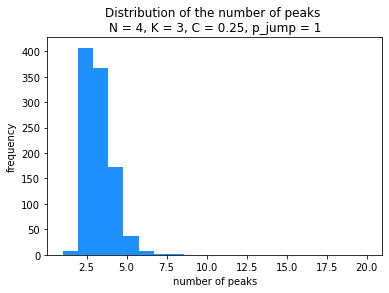

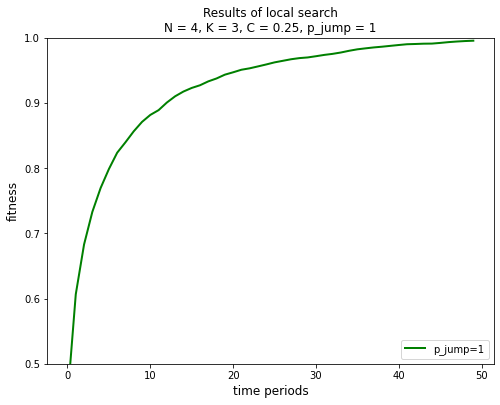

Final fitness level for long jumps: 0.9953060326449887


#######################################################




Run experiment with N = 4, K = 3, C = 0.5, p_jump = 0.0


Summary statistics
N = 4, K = 3, C = 0.5, p_jump = 0.0
average number of peaks: 2.366
maximum number of peaks: 6.0
minimum number of peaks: 2.0
average maximum value: 1.708545421376052
average minimum value: 0.7984129054451966


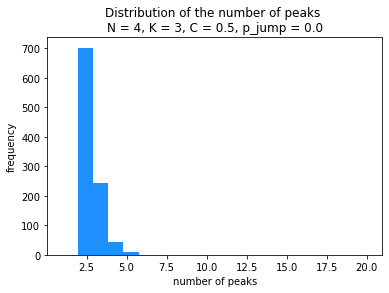

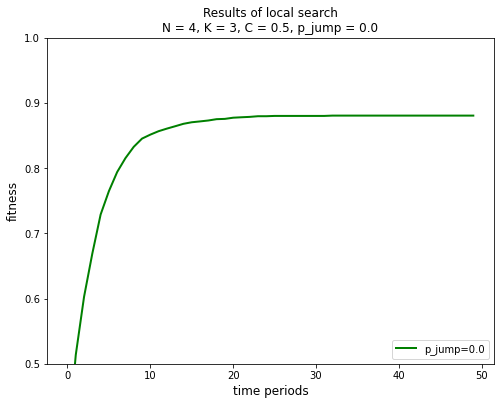

Final fitness level for long jumps: 0.8804856791878513


#######################################################




Run experiment with N = 4, K = 3, C = 0.5, p_jump = 0.5


Summary statistics
N = 4, K = 3, C = 0.5, p_jump = 0.5
average number of peaks: 2.361
maximum number of peaks: 6.0
minimum number of peaks: 2.0
average maximum value: 1.7150354444482163
average minimum value: 0.8043968705216007


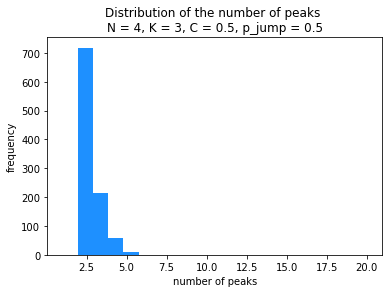

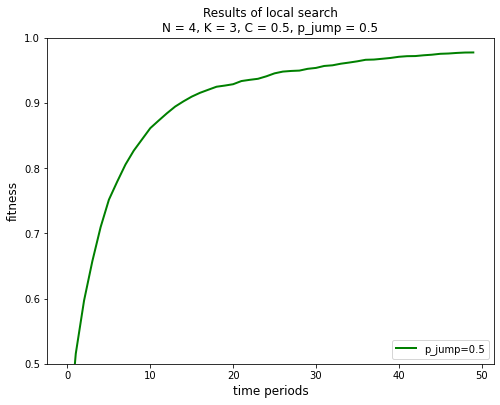

Final fitness level for long jumps: 0.9772866762572437


#######################################################




Run experiment with N = 4, K = 3, C = 0.5, p_jump = 1


Summary statistics
N = 4, K = 3, C = 0.5, p_jump = 1
average number of peaks: 2.389
maximum number of peaks: 6.0
minimum number of peaks: 2.0
average maximum value: 1.703646669500909
average minimum value: 0.805742036597715


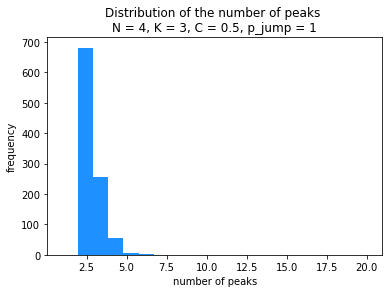

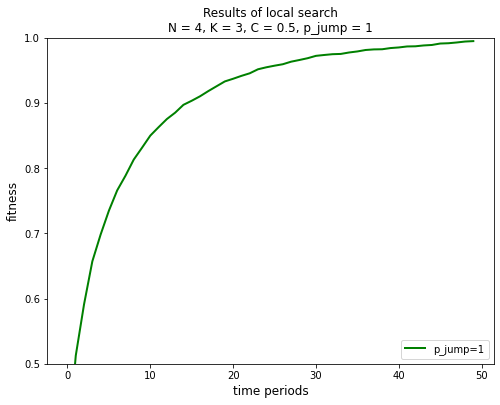

Final fitness level for long jumps: 0.9946699976237654


#######################################################




Run experiment with N = 4, K = 3, C = 0.75, p_jump = 0.0


Summary statistics
N = 4, K = 3, C = 0.75, p_jump = 0.0
average number of peaks: 2.147
maximum number of peaks: 6.0
minimum number of peaks: 2.0
average maximum value: 2.266804009865387
average minimum value: 1.0638351039230038


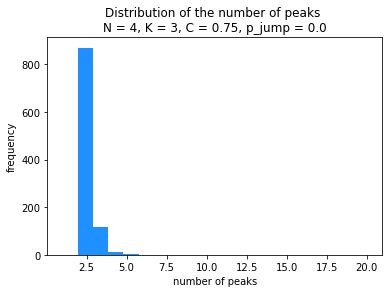

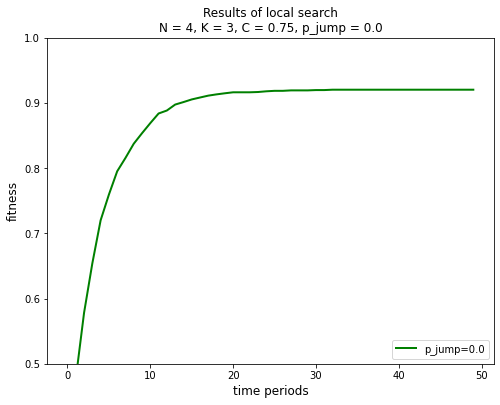

Final fitness level for long jumps: 0.9201893461252717


#######################################################




Run experiment with N = 4, K = 3, C = 0.75, p_jump = 0.5


Summary statistics
N = 4, K = 3, C = 0.75, p_jump = 0.5
average number of peaks: 2.146
maximum number of peaks: 5.0
minimum number of peaks: 2.0
average maximum value: 2.2639136347672184
average minimum value: 1.0620222000876478


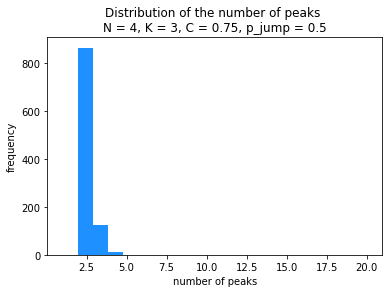

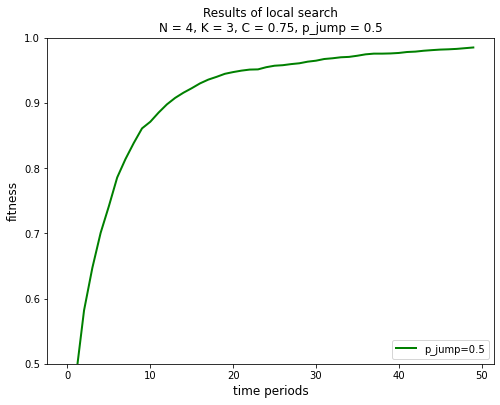

Final fitness level for long jumps: 0.984922952811979


#######################################################




Run experiment with N = 4, K = 3, C = 0.75, p_jump = 1


Summary statistics
N = 4, K = 3, C = 0.75, p_jump = 1
average number of peaks: 2.153
maximum number of peaks: 4.0
minimum number of peaks: 2.0
average maximum value: 2.274742112055811
average minimum value: 1.0618908012304125


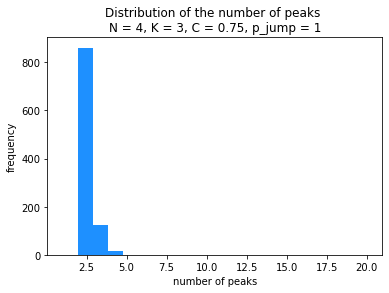

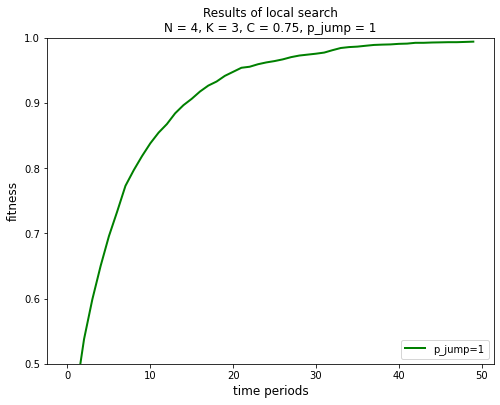

Final fitness level for long jumps: 0.9938565362172626


#######################################################




Run experiment with N = 4, K = 3, C = 1, p_jump = 0.0


Summary statistics
N = 4, K = 3, C = 1, p_jump = 0.0
average number of peaks: 2.051
maximum number of peaks: 4.0
minimum number of peaks: 2.0
average maximum value: 2.8300633836127314
average minimum value: 1.3144747791145914


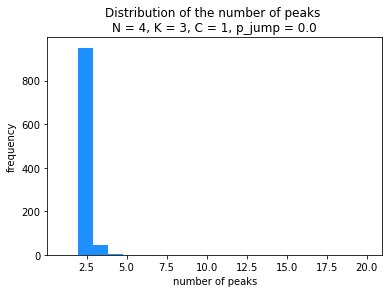

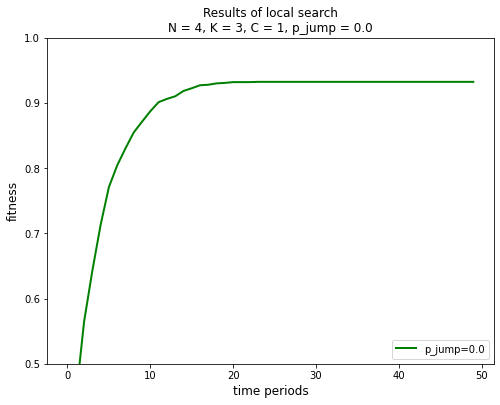

Final fitness level for long jumps: 0.9322294250391819


#######################################################




Run experiment with N = 4, K = 3, C = 1, p_jump = 0.5


Summary statistics
N = 4, K = 3, C = 1, p_jump = 0.5
average number of peaks: 2.061
maximum number of peaks: 4.0
minimum number of peaks: 2.0
average maximum value: 2.839178677929735
average minimum value: 1.3108408497484434


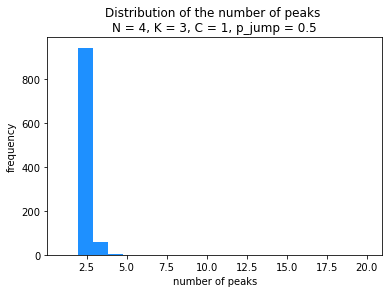

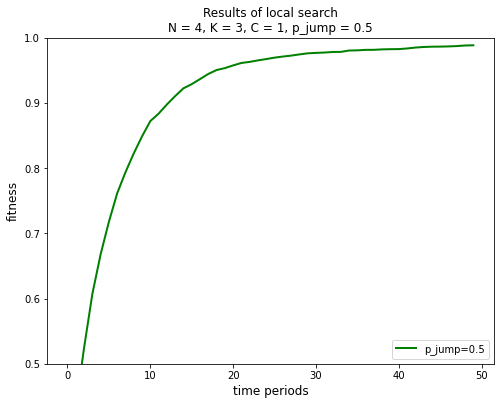

Final fitness level for long jumps: 0.9882619508392978


#######################################################




Run experiment with N = 4, K = 3, C = 1, p_jump = 1


Summary statistics
N = 4, K = 3, C = 1, p_jump = 1
average number of peaks: 2.068
maximum number of peaks: 4.0
minimum number of peaks: 2.0
average maximum value: 2.8261537996721597
average minimum value: 1.3150547724035353


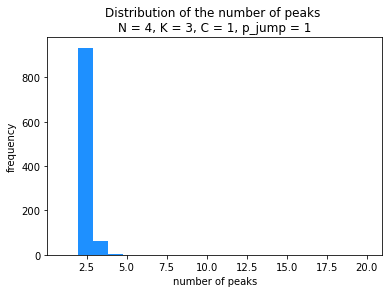

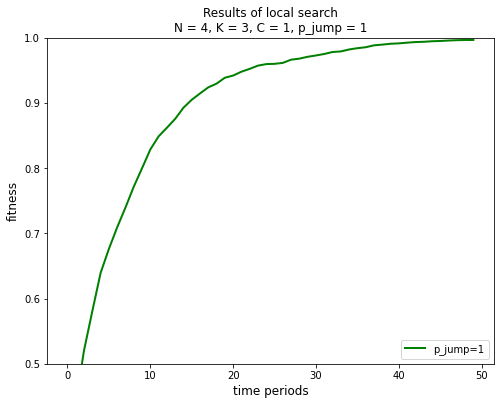

Final fitness level for long jumps: 0.9964215650370969


#######################################################




Run experiment with N = 4, K = 4, C = 0, p_jump = 0.0


Summary statistics
N = 4, K = 4, C = 0, p_jump = 0.0
average number of peaks: 3.172
maximum number of peaks: 7.0
minimum number of peaks: 1.0
average maximum value: 0.7486504225249957
average minimum value: 0.24869234214444552


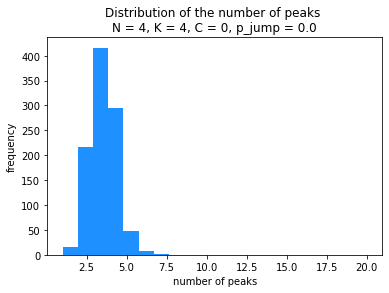

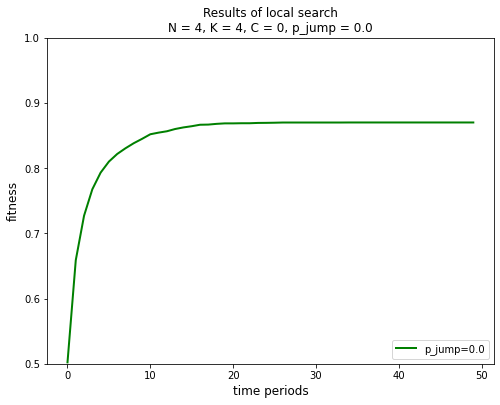

Final fitness level for long jumps: 0.8699547446308139


#######################################################




Run experiment with N = 4, K = 4, C = 0, p_jump = 0.5


Summary statistics
N = 4, K = 4, C = 0, p_jump = 0.5
average number of peaks: 3.203
maximum number of peaks: 7.0
minimum number of peaks: 1.0
average maximum value: 0.7490650229254839
average minimum value: 0.24731697996157453


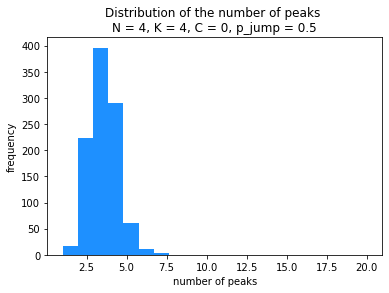

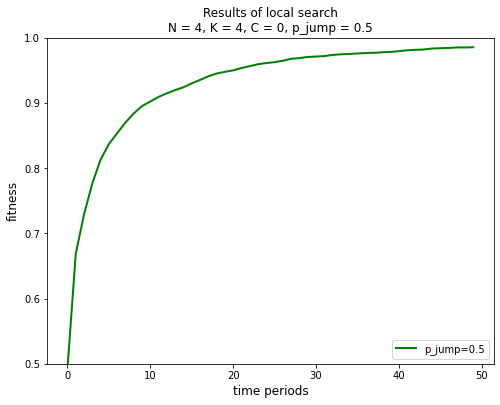

Final fitness level for long jumps: 0.9853225929609459


#######################################################




Run experiment with N = 4, K = 4, C = 0, p_jump = 1


Summary statistics
N = 4, K = 4, C = 0, p_jump = 1
average number of peaks: 3.178
maximum number of peaks: 8.0
minimum number of peaks: 1.0
average maximum value: 0.7520485407302258
average minimum value: 0.24787430850905415


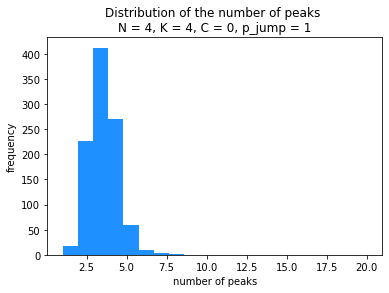

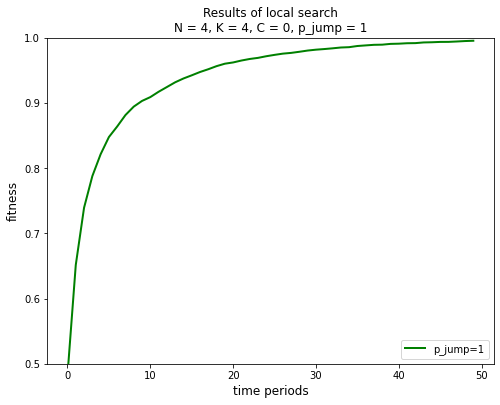

Final fitness level for long jumps: 0.9952251491812321


#######################################################




Run experiment with N = 4, K = 4, C = 0.1, p_jump = 0.0


Summary statistics
N = 4, K = 4, C = 0.1, p_jump = 0.0
average number of peaks: 3.135
maximum number of peaks: 7.0
minimum number of peaks: 1.0
average maximum value: 0.889897438481048
average minimum value: 0.3705736215712071


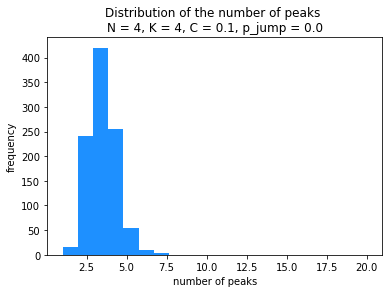

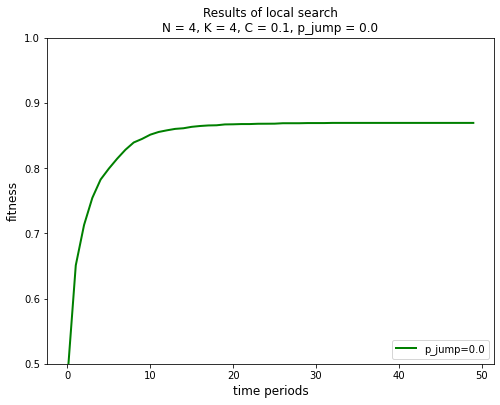

Final fitness level for long jumps: 0.8692934482044236


#######################################################




Run experiment with N = 4, K = 4, C = 0.1, p_jump = 0.5


Summary statistics
N = 4, K = 4, C = 0.1, p_jump = 0.5
average number of peaks: 3.159
maximum number of peaks: 7.0
minimum number of peaks: 1.0
average maximum value: 0.8930380695133202
average minimum value: 0.36895133315811723


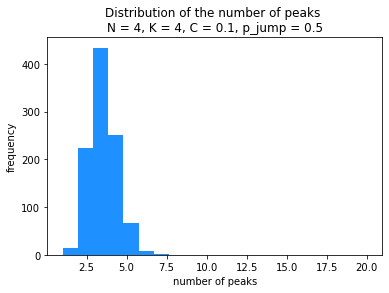

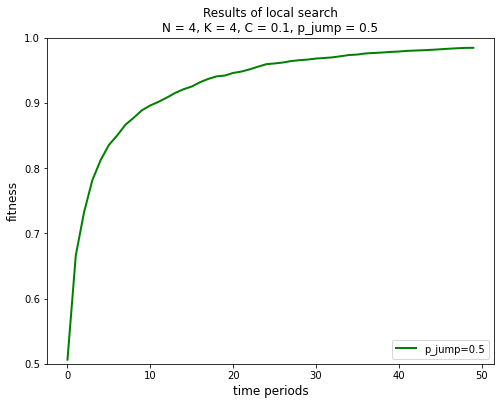

Final fitness level for long jumps: 0.9844286260333488


#######################################################




Run experiment with N = 4, K = 4, C = 0.1, p_jump = 1


Summary statistics
N = 4, K = 4, C = 0.1, p_jump = 1
average number of peaks: 3.186
maximum number of peaks: 7.0
minimum number of peaks: 1.0
average maximum value: 0.8896632728005675
average minimum value: 0.36763135216258774


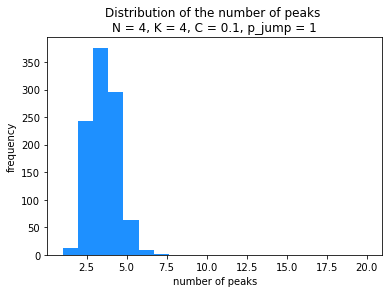

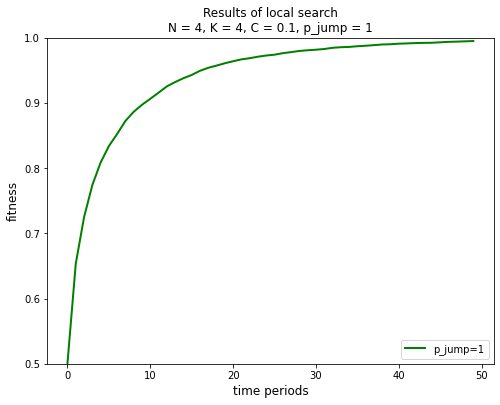

Final fitness level for long jumps: 0.9947977693790646


#######################################################




Run experiment with N = 4, K = 4, C = 0.25, p_jump = 0.0


Summary statistics
N = 4, K = 4, C = 0.25, p_jump = 0.0
average number of peaks: 2.76
maximum number of peaks: 8.0
minimum number of peaks: 1.0
average maximum value: 1.1598636537744456
average minimum value: 0.5364802204025009


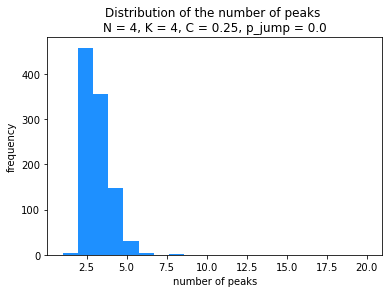

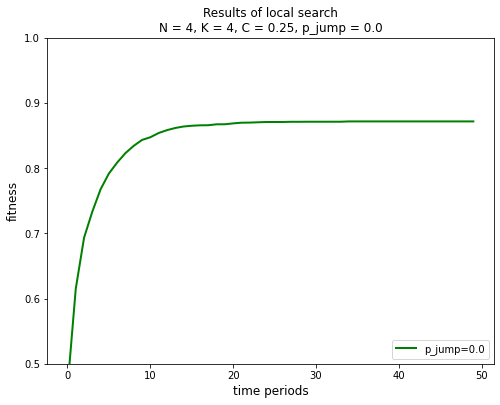

Final fitness level for long jumps: 0.871577754409623


#######################################################




Run experiment with N = 4, K = 4, C = 0.25, p_jump = 0.5


Summary statistics
N = 4, K = 4, C = 0.25, p_jump = 0.5
average number of peaks: 2.831
maximum number of peaks: 6.0
minimum number of peaks: 1.0
average maximum value: 1.1595586165704734
average minimum value: 0.5344755576471418


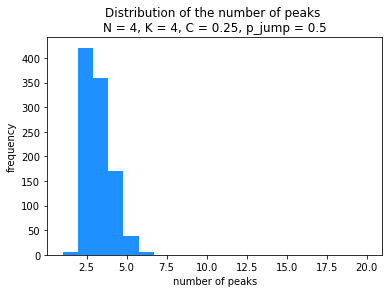

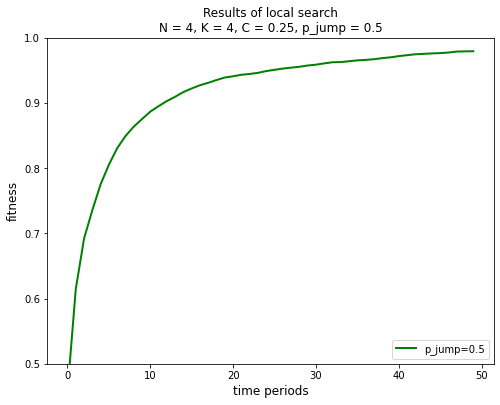

Final fitness level for long jumps: 0.9791669100323385


#######################################################




Run experiment with N = 4, K = 4, C = 0.25, p_jump = 1


Summary statistics
N = 4, K = 4, C = 0.25, p_jump = 1
average number of peaks: 2.86
maximum number of peaks: 7.0
minimum number of peaks: 1.0
average maximum value: 1.1557388291549113
average minimum value: 0.5356989287210195


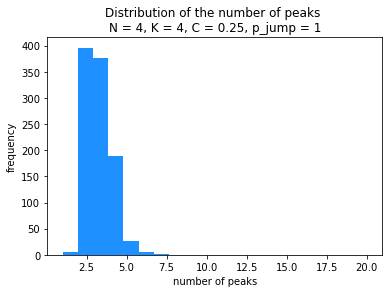

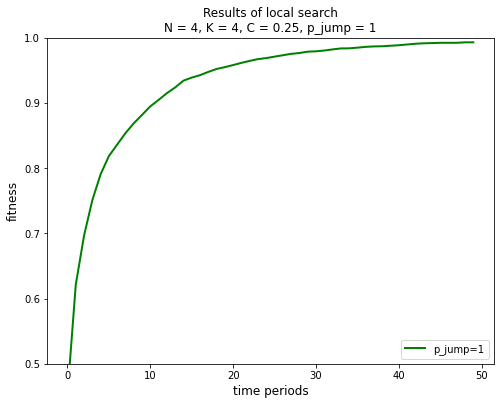

Final fitness level for long jumps: 0.9928519825954607


#######################################################




Run experiment with N = 4, K = 4, C = 0.5, p_jump = 0.0


Summary statistics
N = 4, K = 4, C = 0.5, p_jump = 0.0
average number of peaks: 2.344
maximum number of peaks: 5.0
minimum number of peaks: 2.0
average maximum value: 1.7074229829110847
average minimum value: 0.8030297488060132


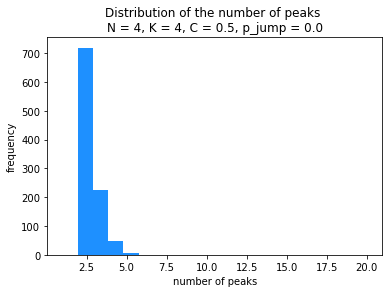

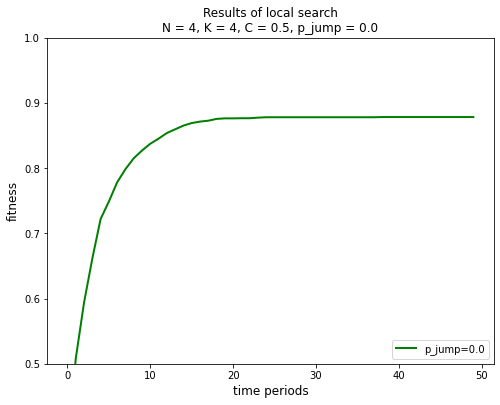

Final fitness level for long jumps: 0.8782777776614863


#######################################################




Run experiment with N = 4, K = 4, C = 0.5, p_jump = 0.5


Summary statistics
N = 4, K = 4, C = 0.5, p_jump = 0.5
average number of peaks: 2.354
maximum number of peaks: 6.0
minimum number of peaks: 2.0
average maximum value: 1.703734110904248
average minimum value: 0.8022413628578896


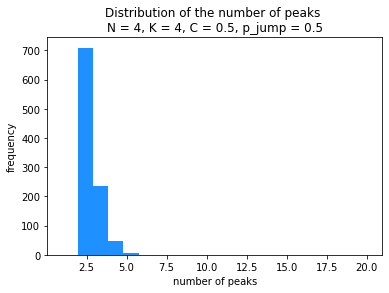

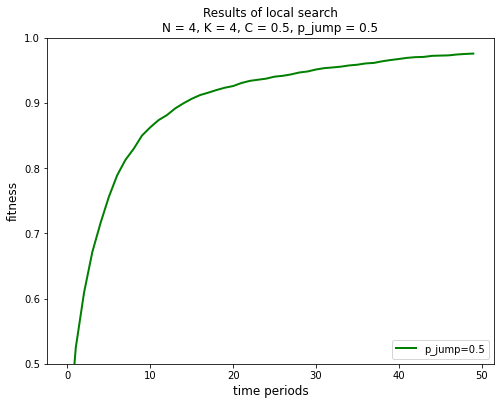

Final fitness level for long jumps: 0.97555069503981


#######################################################




Run experiment with N = 4, K = 4, C = 0.5, p_jump = 1


Summary statistics
N = 4, K = 4, C = 0.5, p_jump = 1
average number of peaks: 2.335
maximum number of peaks: 5.0
minimum number of peaks: 2.0
average maximum value: 1.7050474793978905
average minimum value: 0.8014145890462184


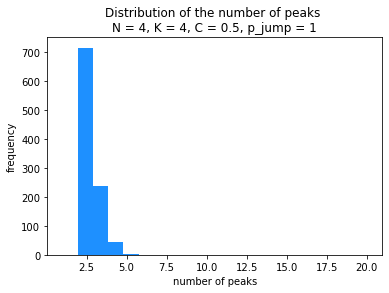

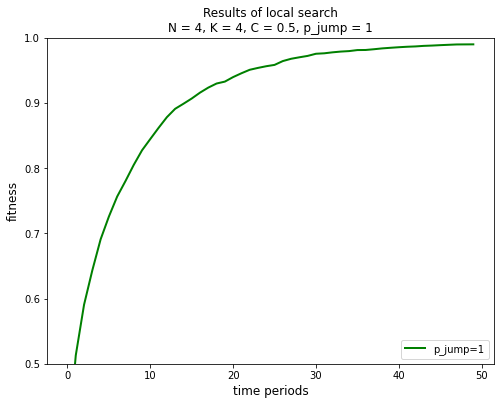

Final fitness level for long jumps: 0.9897126210459074


#######################################################




Run experiment with N = 4, K = 4, C = 0.75, p_jump = 0.0


Summary statistics
N = 4, K = 4, C = 0.75, p_jump = 0.0
average number of peaks: 2.171
maximum number of peaks: 5.0
minimum number of peaks: 2.0
average maximum value: 2.266166355230458
average minimum value: 1.0648620487865406


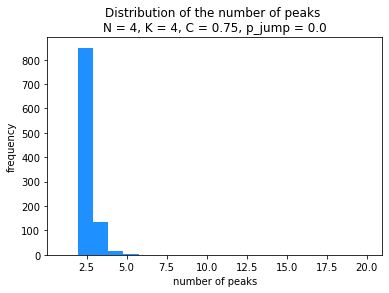

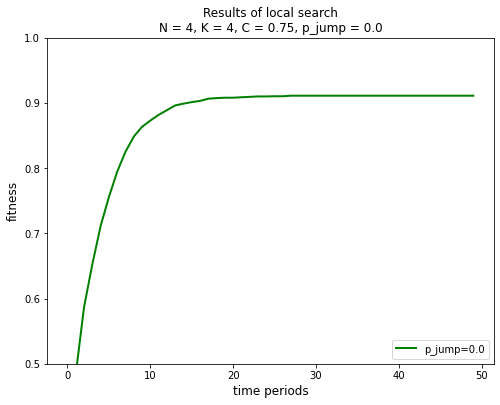

Final fitness level for long jumps: 0.9110159654684116


#######################################################




Run experiment with N = 4, K = 4, C = 0.75, p_jump = 0.5


Summary statistics
N = 4, K = 4, C = 0.75, p_jump = 0.5
average number of peaks: 2.172
maximum number of peaks: 5.0
minimum number of peaks: 2.0
average maximum value: 2.266850626779483
average minimum value: 1.066958634569129


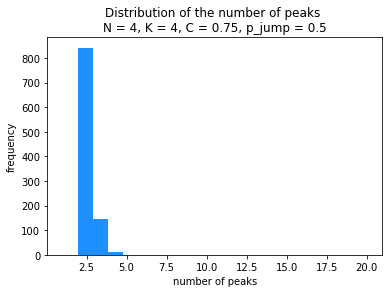

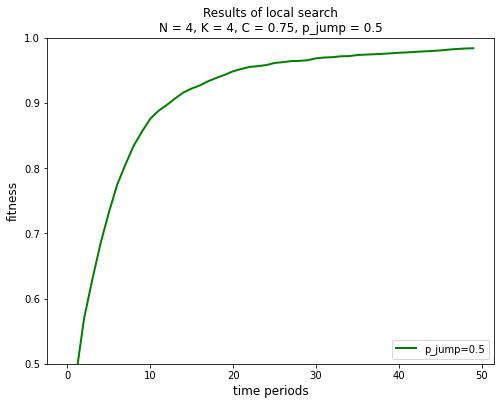

Final fitness level for long jumps: 0.9837494547855103


#######################################################




Run experiment with N = 4, K = 4, C = 0.75, p_jump = 1


Summary statistics
N = 4, K = 4, C = 0.75, p_jump = 1
average number of peaks: 2.148
maximum number of peaks: 5.0
minimum number of peaks: 2.0
average maximum value: 2.266386788743249
average minimum value: 1.062266281843062


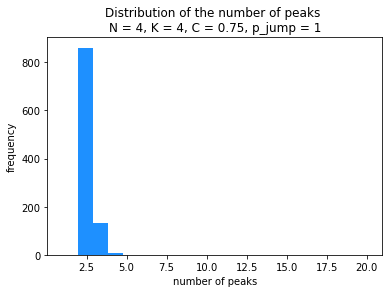

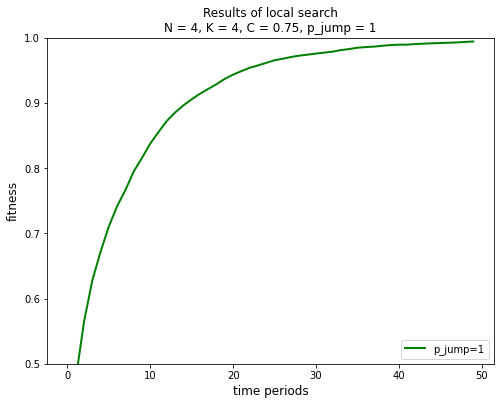

Final fitness level for long jumps: 0.99407044610161


#######################################################




Run experiment with N = 4, K = 4, C = 1, p_jump = 0.0


Summary statistics
N = 4, K = 4, C = 1, p_jump = 0.0
average number of peaks: 2.056
maximum number of peaks: 3.0
minimum number of peaks: 2.0
average maximum value: 2.833244268058861
average minimum value: 1.3142392258375981


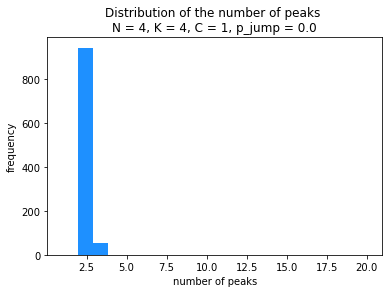

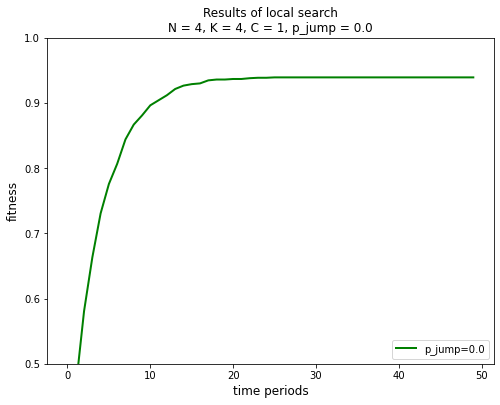

Final fitness level for long jumps: 0.9390816935627063


#######################################################




Run experiment with N = 4, K = 4, C = 1, p_jump = 0.5


Summary statistics
N = 4, K = 4, C = 1, p_jump = 0.5
average number of peaks: 2.067
maximum number of peaks: 4.0
minimum number of peaks: 2.0
average maximum value: 2.832910396607434
average minimum value: 1.3147649479970491


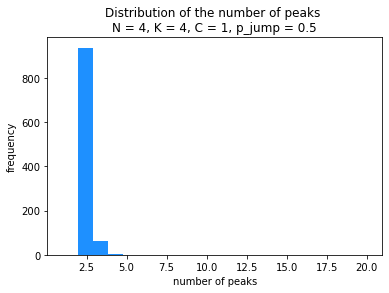

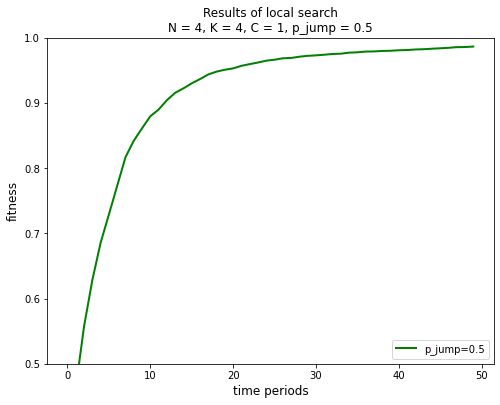

Final fitness level for long jumps: 0.9863397326610561


#######################################################




Run experiment with N = 4, K = 4, C = 1, p_jump = 1


Summary statistics
N = 4, K = 4, C = 1, p_jump = 1
average number of peaks: 2.058
maximum number of peaks: 3.0
minimum number of peaks: 2.0
average maximum value: 2.8354523187150016
average minimum value: 1.3132333048610931


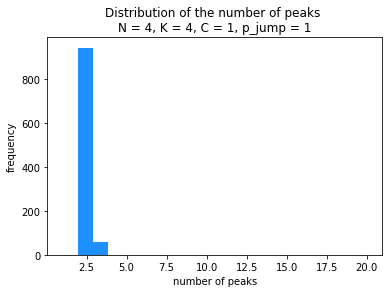

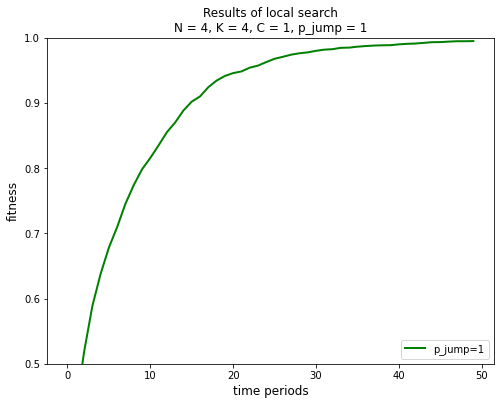

Final fitness level for long jumps: 0.9947215317622009


#######################################################




Run experiment with N = 6, K = 0, C = 0, p_jump = 0.0


Summary statistics
N = 6, K = 0, C = 0, p_jump = 0.0
average number of peaks: 1.0
maximum number of peaks: 1.0
minimum number of peaks: 1.0
average maximum value: 0.667265583090479
average minimum value: 0.33422833027065985


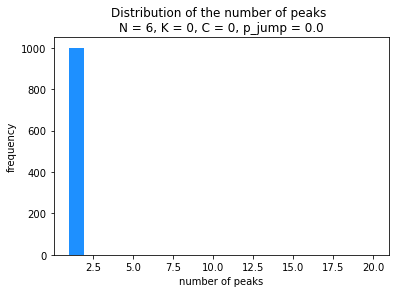

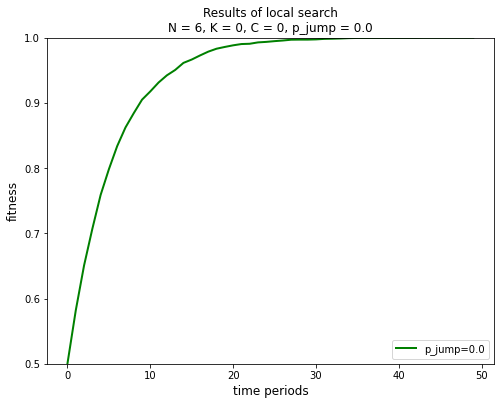

Final fitness level for long jumps: 1.0


#######################################################




Run experiment with N = 6, K = 0, C = 0, p_jump = 0.5


Summary statistics
N = 6, K = 0, C = 0, p_jump = 0.5
average number of peaks: 1.0
maximum number of peaks: 1.0
minimum number of peaks: 1.0
average maximum value: 0.666532917640372
average minimum value: 0.331203429780717


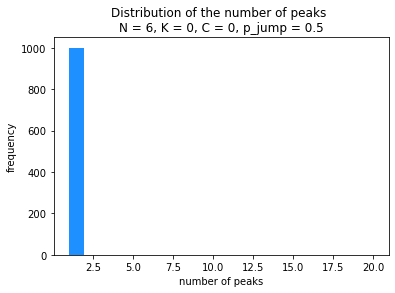

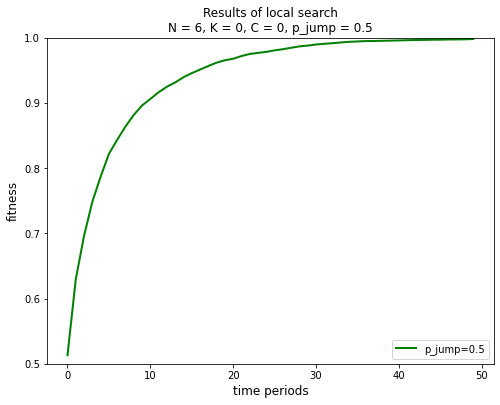

Final fitness level for long jumps: 0.9978528083954202


#######################################################




Run experiment with N = 6, K = 0, C = 0, p_jump = 1


Summary statistics
N = 6, K = 0, C = 0, p_jump = 1
average number of peaks: 1.0
maximum number of peaks: 1.0
minimum number of peaks: 1.0
average maximum value: 0.6688410917717106
average minimum value: 0.3312285749997564


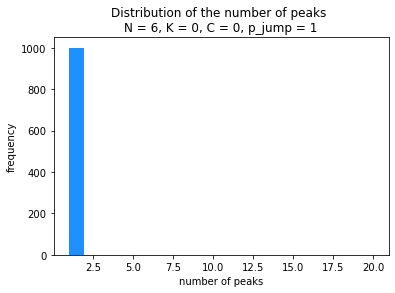

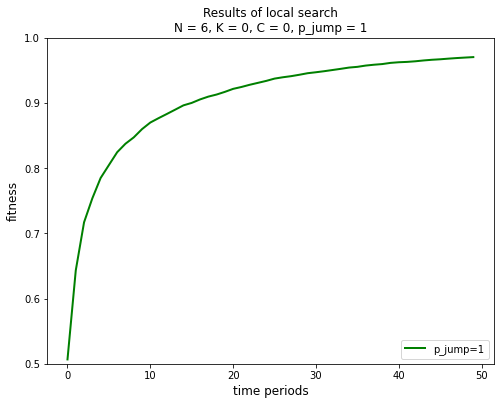

Final fitness level for long jumps: 0.9701579413144049


#######################################################




Run experiment with N = 6, K = 0, C = 0.1, p_jump = 0.0


Summary statistics
N = 6, K = 0, C = 0.1, p_jump = 0.0
average number of peaks: 2.227
maximum number of peaks: 4.0
minimum number of peaks: 1.0
average maximum value: 0.9026333570884535
average minimum value: 0.44378334316358625


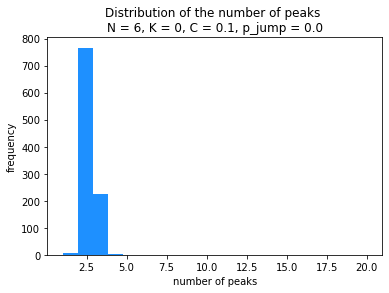

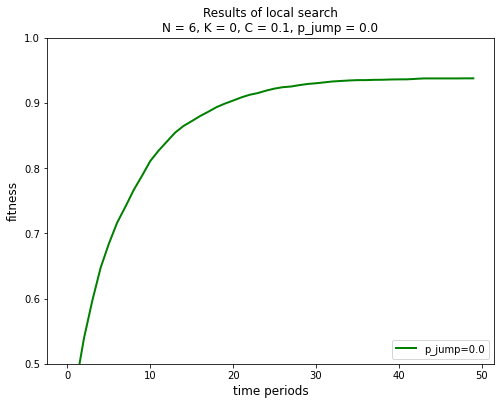

Final fitness level for long jumps: 0.9376051131582641


#######################################################




Run experiment with N = 6, K = 0, C = 0.1, p_jump = 0.5


Summary statistics
N = 6, K = 0, C = 0.1, p_jump = 0.5
average number of peaks: 2.216
maximum number of peaks: 4.0
minimum number of peaks: 1.0
average maximum value: 0.902084238632056
average minimum value: 0.44356856525218846


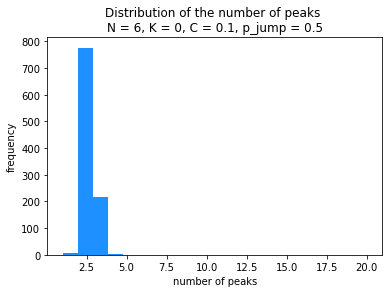

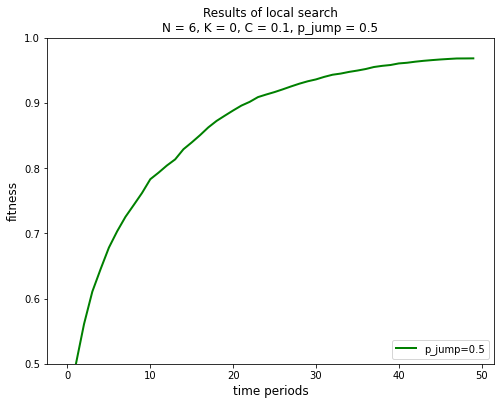

Final fitness level for long jumps: 0.9682309217303136


#######################################################




Run experiment with N = 6, K = 0, C = 0.1, p_jump = 1


Summary statistics
N = 6, K = 0, C = 0.1, p_jump = 1
average number of peaks: 2.22
maximum number of peaks: 4.0
minimum number of peaks: 1.0
average maximum value: 0.9091076427761378
average minimum value: 0.45015920888227773


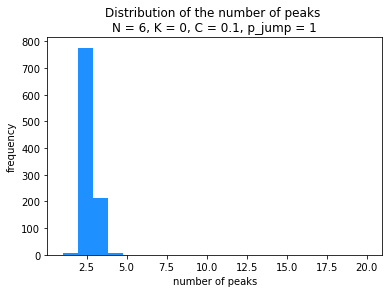

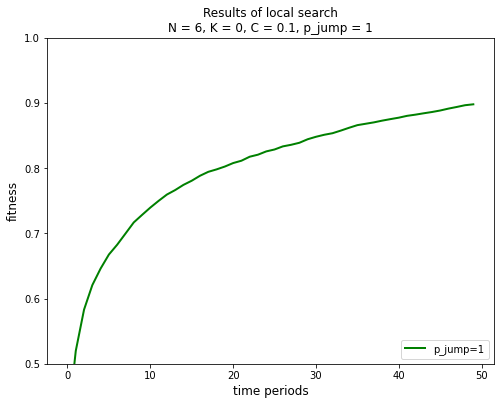

Final fitness level for long jumps: 0.8977941419912675


#######################################################




Run experiment with N = 6, K = 0, C = 0.25, p_jump = 0.0


Summary statistics
N = 6, K = 0, C = 0.25, p_jump = 0.0
average number of peaks: 2.009
maximum number of peaks: 3.0
minimum number of peaks: 2.0
average maximum value: 1.4130692673744403
average minimum value: 0.6057404086061793


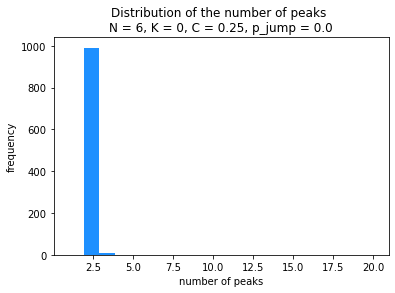

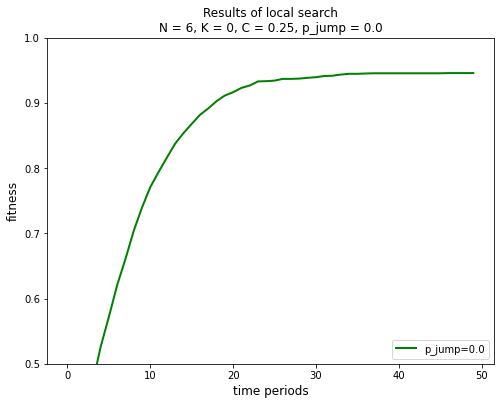

Final fitness level for long jumps: 0.9456782683336038


#######################################################




Run experiment with N = 6, K = 0, C = 0.25, p_jump = 0.5


Summary statistics
N = 6, K = 0, C = 0.25, p_jump = 0.5
average number of peaks: 2.01
maximum number of peaks: 3.0
minimum number of peaks: 2.0
average maximum value: 1.4101282095458092
average minimum value: 0.6027965585715865


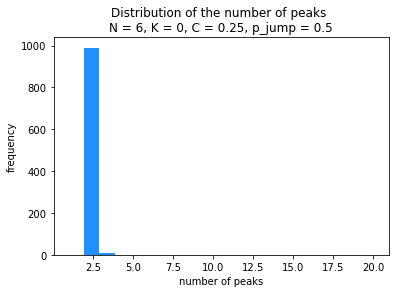

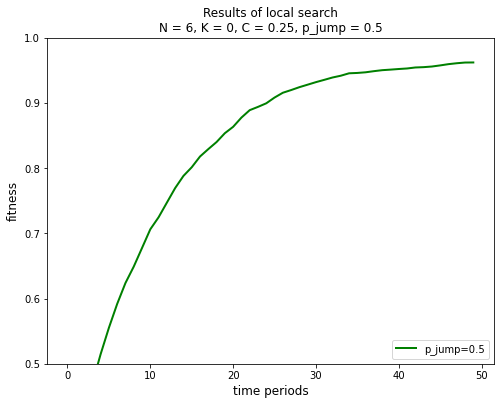

Final fitness level for long jumps: 0.9619535137000381


#######################################################




Run experiment with N = 6, K = 0, C = 0.25, p_jump = 1


Summary statistics
N = 6, K = 0, C = 0.25, p_jump = 1
average number of peaks: 2.008
maximum number of peaks: 3.0
minimum number of peaks: 2.0
average maximum value: 1.4149268945710736
average minimum value: 0.6030377617945762


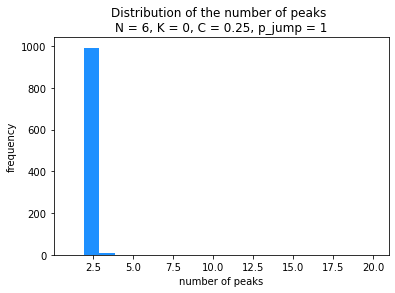

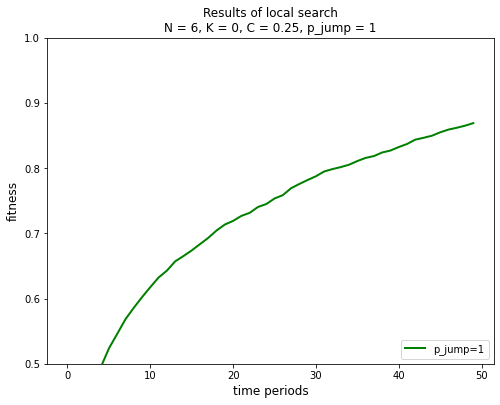

Final fitness level for long jumps: 0.8689473084144752


#######################################################




Run experiment with N = 6, K = 0, C = 0.5, p_jump = 0.0


Summary statistics
N = 6, K = 0, C = 0.5, p_jump = 0.0
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 2.2558179864089833
average minimum value: 0.857283390372406


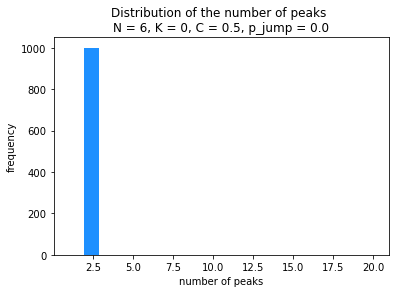

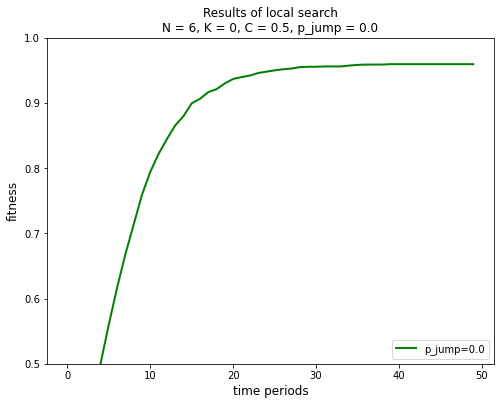

Final fitness level for long jumps: 0.9593503502563515


#######################################################




Run experiment with N = 6, K = 0, C = 0.5, p_jump = 0.5


Summary statistics
N = 6, K = 0, C = 0.5, p_jump = 0.5
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 2.2515323088217776
average minimum value: 0.8501415970694428


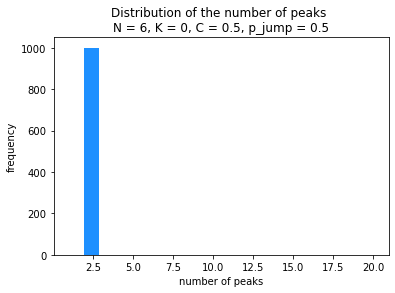

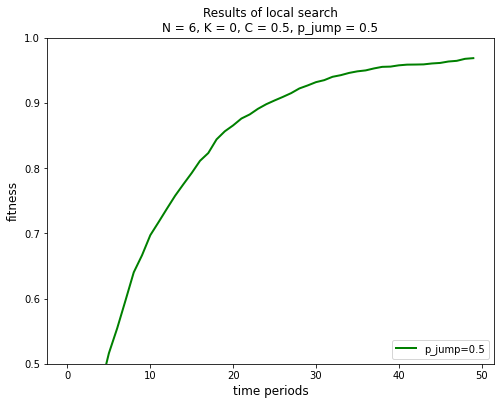

Final fitness level for long jumps: 0.9685506854781555


#######################################################




Run experiment with N = 6, K = 0, C = 0.5, p_jump = 1


Summary statistics
N = 6, K = 0, C = 0.5, p_jump = 1
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 2.2522485488698614
average minimum value: 0.8536956206323594


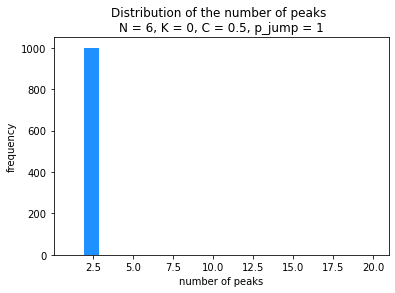

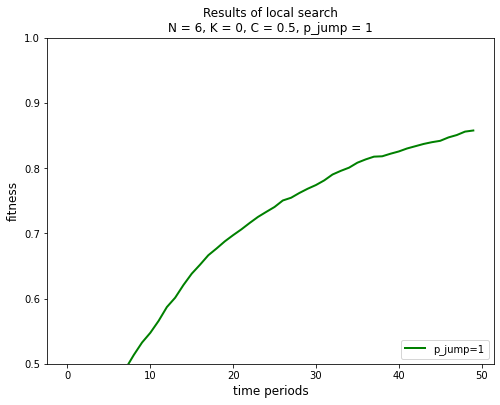

Final fitness level for long jumps: 0.8576559950293748


#######################################################




Run experiment with N = 6, K = 0, C = 0.75, p_jump = 0.0


Summary statistics
N = 6, K = 0, C = 0.75, p_jump = 0.0
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 3.0935964267076623
average minimum value: 1.098645615711801


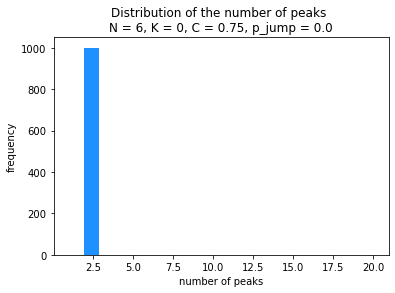

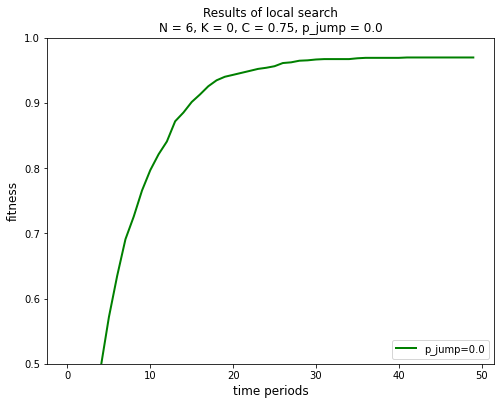

Final fitness level for long jumps: 0.9695929960617821


#######################################################




Run experiment with N = 6, K = 0, C = 0.75, p_jump = 0.5


Summary statistics
N = 6, K = 0, C = 0.75, p_jump = 0.5
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 3.0985868922794793
average minimum value: 1.1025916625377206


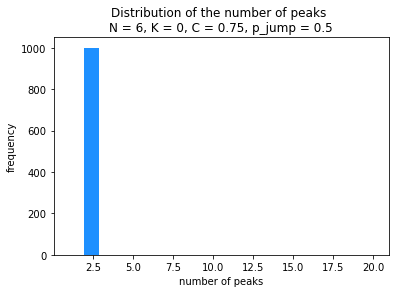

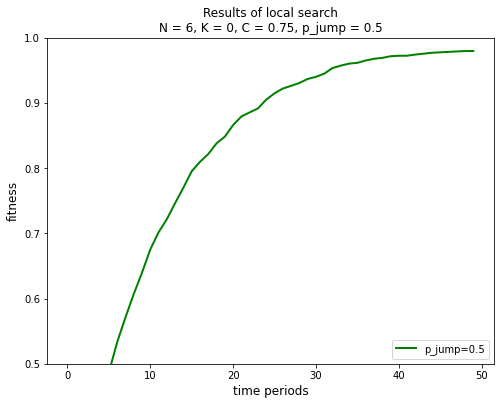

Final fitness level for long jumps: 0.9795426949751028


#######################################################




Run experiment with N = 6, K = 0, C = 0.75, p_jump = 1


Summary statistics
N = 6, K = 0, C = 0.75, p_jump = 1
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 3.1012340377834606
average minimum value: 1.1090399335884145


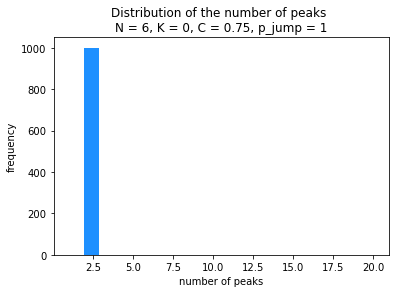

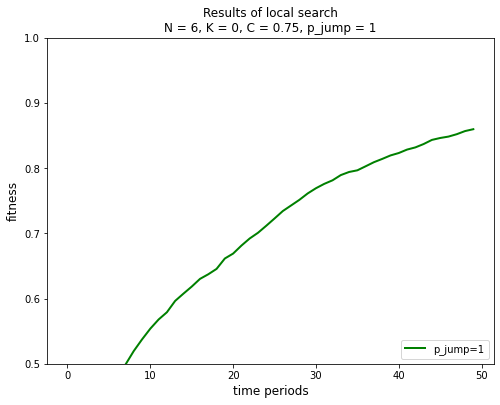

Final fitness level for long jumps: 0.8596399800033232


#######################################################




Run experiment with N = 6, K = 0, C = 1, p_jump = 0.0


Summary statistics
N = 6, K = 0, C = 1, p_jump = 0.0
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 3.9436559235817867
average minimum value: 1.353604204274017


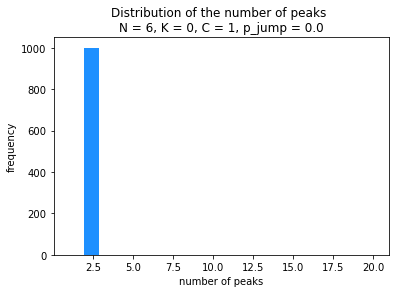

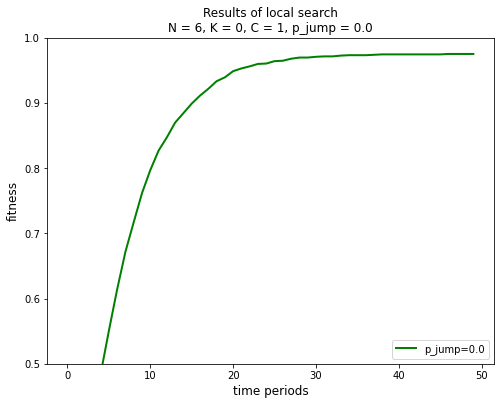

Final fitness level for long jumps: 0.9749763148487913


#######################################################




Run experiment with N = 6, K = 0, C = 1, p_jump = 0.5


Summary statistics
N = 6, K = 0, C = 1, p_jump = 0.5
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 3.9448303879693336
average minimum value: 1.3538121596022161


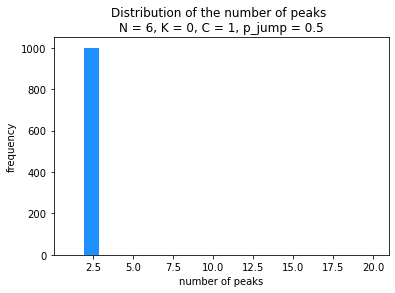

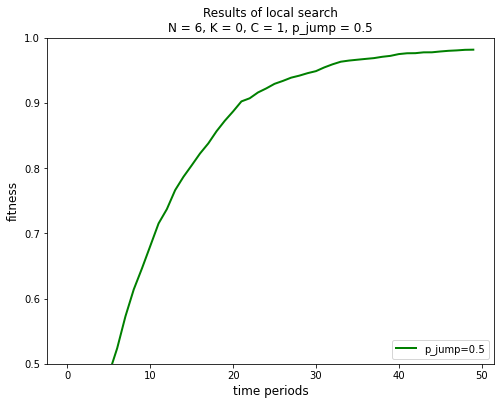

Final fitness level for long jumps: 0.9815386790689502


#######################################################




Run experiment with N = 6, K = 0, C = 1, p_jump = 1


Summary statistics
N = 6, K = 0, C = 1, p_jump = 1
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 3.9407375608592714
average minimum value: 1.3514682437067222


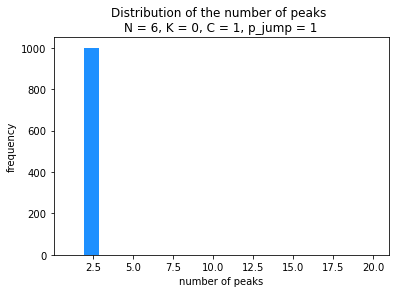

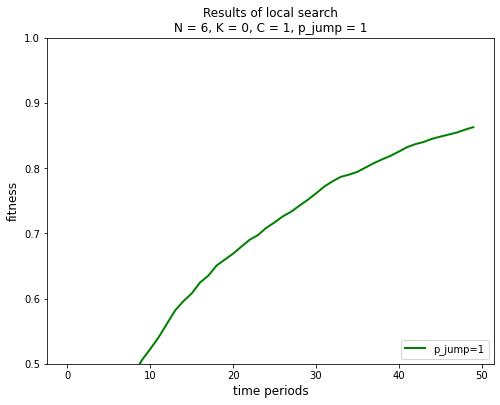

Final fitness level for long jumps: 0.8627622227502992


#######################################################




Run experiment with N = 6, K = 2, C = 0, p_jump = 0.0


Summary statistics
N = 6, K = 2, C = 0, p_jump = 0.0
average number of peaks: 3.467
maximum number of peaks: 8.0
minimum number of peaks: 1.0
average maximum value: 0.7418794021848372
average minimum value: 0.2578432800449259


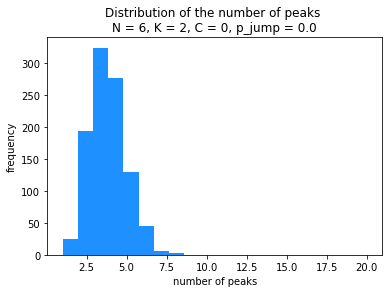

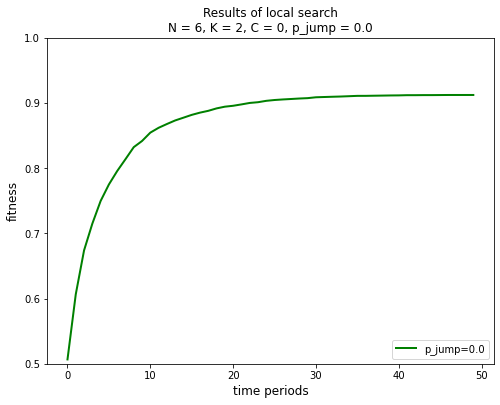

Final fitness level for long jumps: 0.912104054103602


#######################################################




Run experiment with N = 6, K = 2, C = 0, p_jump = 0.5


Summary statistics
N = 6, K = 2, C = 0, p_jump = 0.5
average number of peaks: 3.471
maximum number of peaks: 8.0
minimum number of peaks: 1.0
average maximum value: 0.7418759240117767
average minimum value: 0.26034094665097074


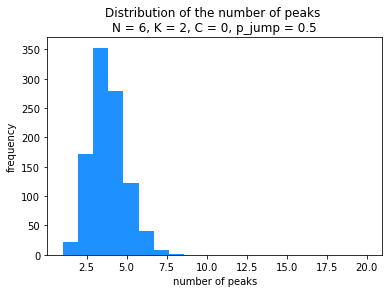

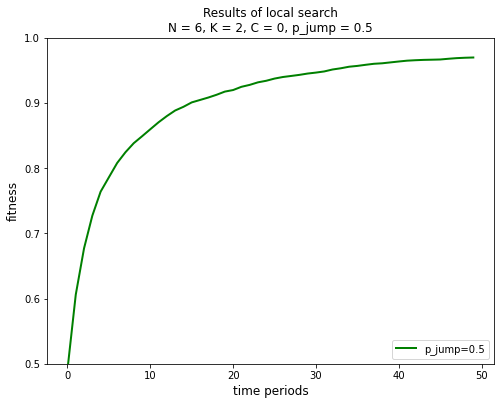

Final fitness level for long jumps: 0.9695637300309925


#######################################################




Run experiment with N = 6, K = 2, C = 0, p_jump = 1


Summary statistics
N = 6, K = 2, C = 0, p_jump = 1
average number of peaks: 3.437
maximum number of peaks: 8.0
minimum number of peaks: 1.0
average maximum value: 0.7395019157418028
average minimum value: 0.25799266439048146


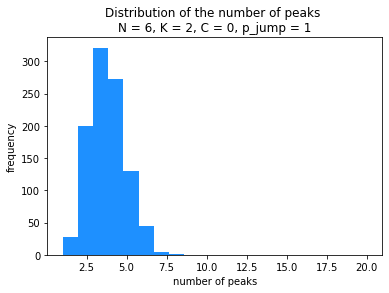

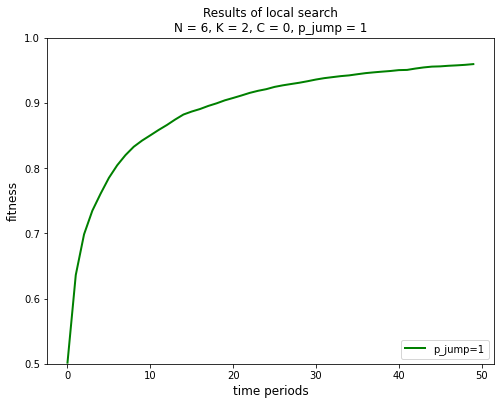

Final fitness level for long jumps: 0.9594277594233539


#######################################################




Run experiment with N = 6, K = 2, C = 0.1, p_jump = 0.0


Summary statistics
N = 6, K = 2, C = 0.1, p_jump = 0.0
average number of peaks: 3.518
maximum number of peaks: 8.0
minimum number of peaks: 1.0
average maximum value: 0.9278954470181343
average minimum value: 0.37382607634188914


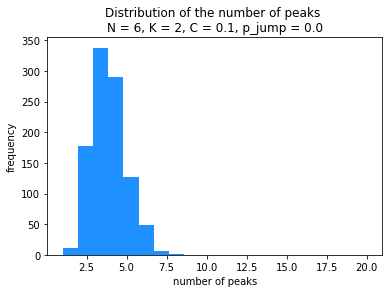

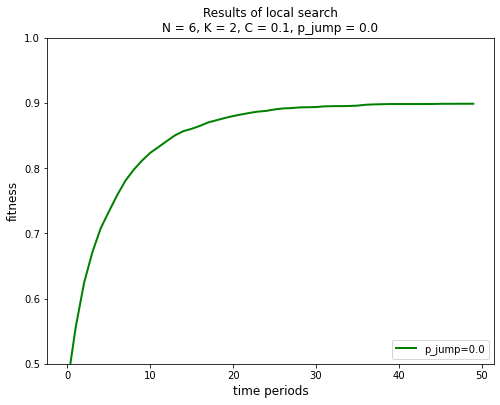

Final fitness level for long jumps: 0.8986664663245051


#######################################################




Run experiment with N = 6, K = 2, C = 0.1, p_jump = 0.5


Summary statistics
N = 6, K = 2, C = 0.1, p_jump = 0.5
average number of peaks: 3.45
maximum number of peaks: 9.0
minimum number of peaks: 1.0
average maximum value: 0.9296487014495827
average minimum value: 0.3739949286033884


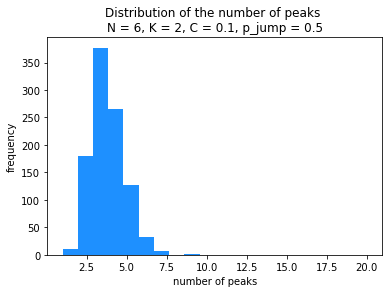

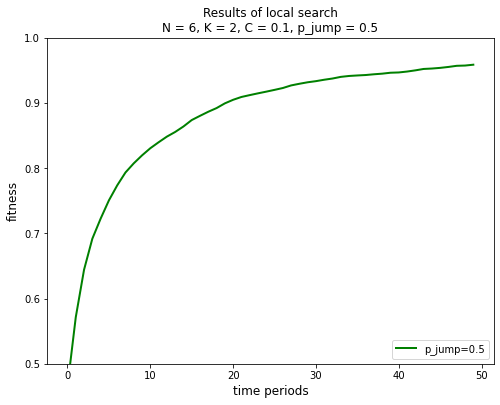

Final fitness level for long jumps: 0.958506286404532


#######################################################




Run experiment with N = 6, K = 2, C = 0.1, p_jump = 1


Summary statistics
N = 6, K = 2, C = 0.1, p_jump = 1
average number of peaks: 3.472
maximum number of peaks: 7.0
minimum number of peaks: 1.0
average maximum value: 0.9294094689545215
average minimum value: 0.37618446191258864


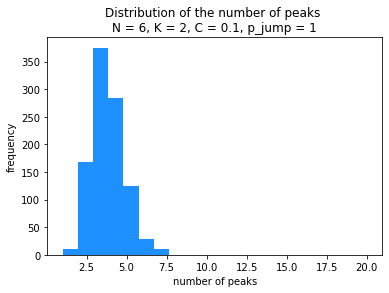

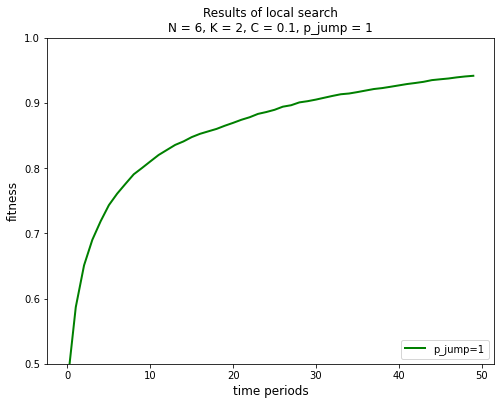

Final fitness level for long jumps: 0.9415159709597692


#######################################################




Run experiment with N = 6, K = 2, C = 0.25, p_jump = 0.0


Summary statistics
N = 6, K = 2, C = 0.25, p_jump = 0.0
average number of peaks: 2.563
maximum number of peaks: 7.0
minimum number of peaks: 2.0
average maximum value: 1.4104387728565115
average minimum value: 0.5395245357989655


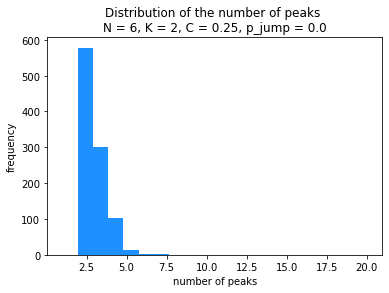

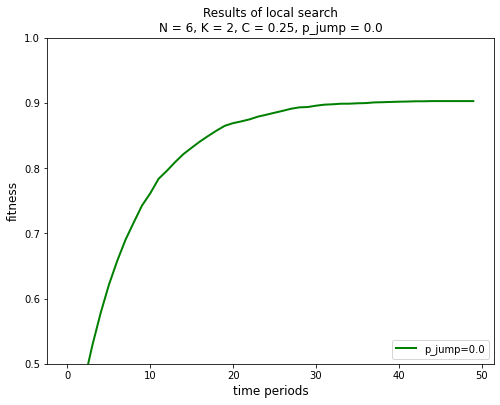

Final fitness level for long jumps: 0.902727016826362


#######################################################




Run experiment with N = 6, K = 2, C = 0.25, p_jump = 0.5


Summary statistics
N = 6, K = 2, C = 0.25, p_jump = 0.5
average number of peaks: 2.594
maximum number of peaks: 6.0
minimum number of peaks: 2.0
average maximum value: 1.4083214145540128
average minimum value: 0.5345360338636858


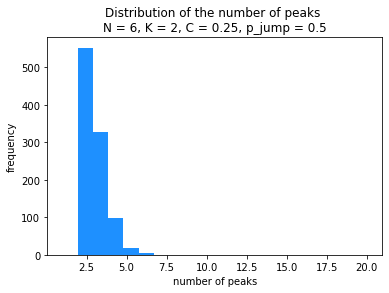

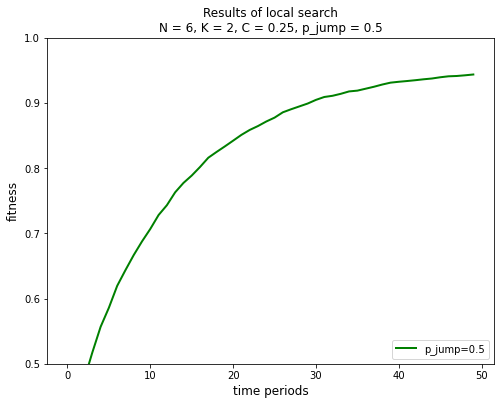

Final fitness level for long jumps: 0.9435069375833374


#######################################################




Run experiment with N = 6, K = 2, C = 0.25, p_jump = 1


Summary statistics
N = 6, K = 2, C = 0.25, p_jump = 1
average number of peaks: 2.552
maximum number of peaks: 6.0
minimum number of peaks: 2.0
average maximum value: 1.411826492204927
average minimum value: 0.5349485765338252


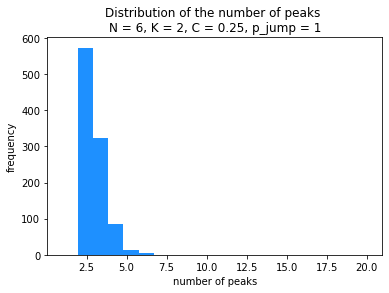

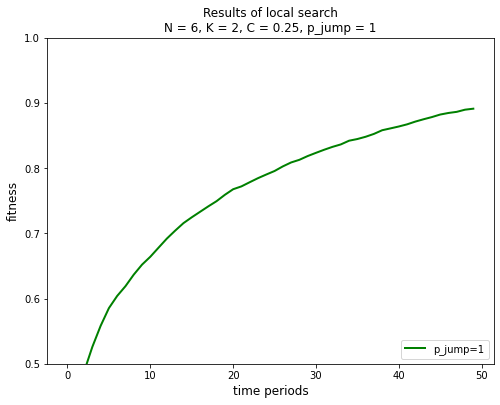

Final fitness level for long jumps: 0.8910711089948701


#######################################################




Run experiment with N = 6, K = 2, C = 0.5, p_jump = 0.0


Summary statistics
N = 6, K = 2, C = 0.5, p_jump = 0.0
average number of peaks: 2.055
maximum number of peaks: 4.0
minimum number of peaks: 2.0
average maximum value: 2.248260963884414
average minimum value: 0.7944934283889491


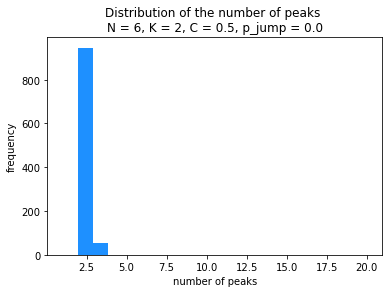

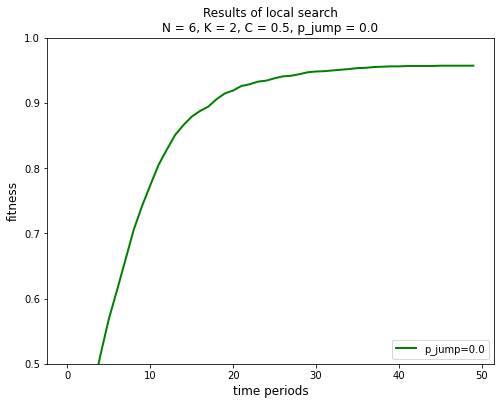

Final fitness level for long jumps: 0.9569978841345372


#######################################################




Run experiment with N = 6, K = 2, C = 0.5, p_jump = 0.5


Summary statistics
N = 6, K = 2, C = 0.5, p_jump = 0.5
average number of peaks: 2.046
maximum number of peaks: 4.0
minimum number of peaks: 2.0
average maximum value: 2.254524354123949
average minimum value: 0.7894382044320284


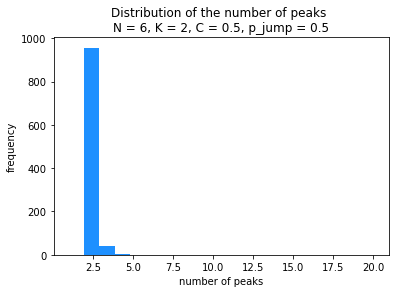

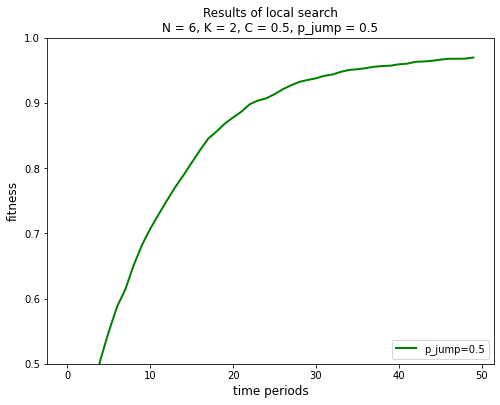

Final fitness level for long jumps: 0.9694515863097393


#######################################################




Run experiment with N = 6, K = 2, C = 0.5, p_jump = 1


Summary statistics
N = 6, K = 2, C = 0.5, p_jump = 1
average number of peaks: 2.063
maximum number of peaks: 4.0
minimum number of peaks: 2.0
average maximum value: 2.258592217682035
average minimum value: 0.7939153124877376


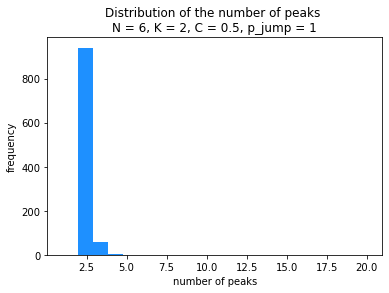

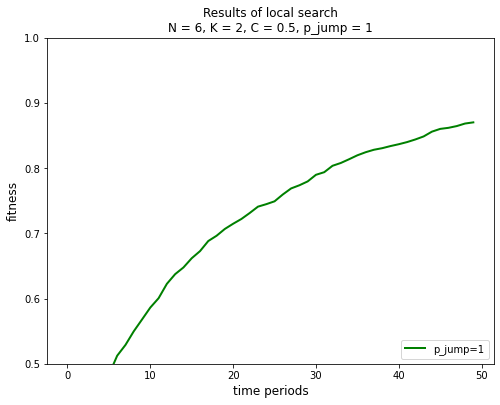

Final fitness level for long jumps: 0.870122618786063


#######################################################




Run experiment with N = 6, K = 2, C = 0.75, p_jump = 0.0


Summary statistics
N = 6, K = 2, C = 0.75, p_jump = 0.0
average number of peaks: 2.003
maximum number of peaks: 3.0
minimum number of peaks: 2.0
average maximum value: 3.1019593795188576
average minimum value: 1.0433722954252


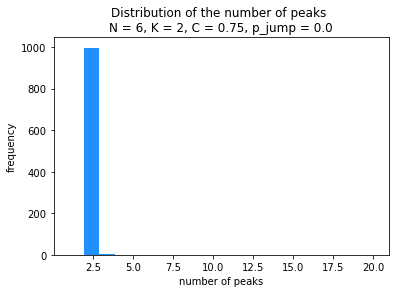

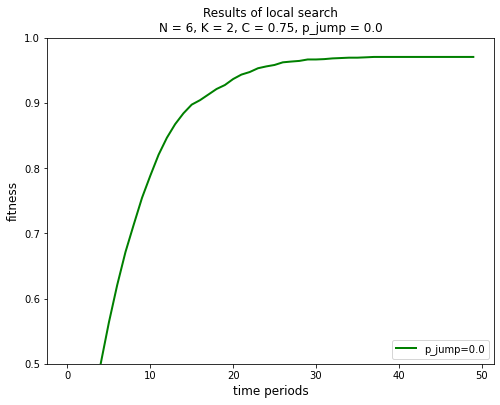

Final fitness level for long jumps: 0.970418114682459


#######################################################




Run experiment with N = 6, K = 2, C = 0.75, p_jump = 0.5


Summary statistics
N = 6, K = 2, C = 0.75, p_jump = 0.5
average number of peaks: 2.007
maximum number of peaks: 3.0
minimum number of peaks: 2.0
average maximum value: 3.098632082443341
average minimum value: 1.0466629428917977


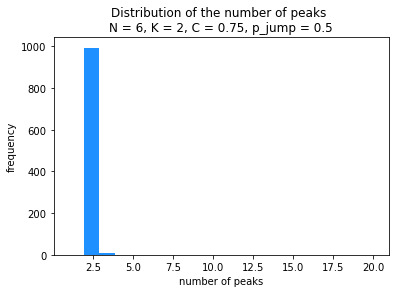

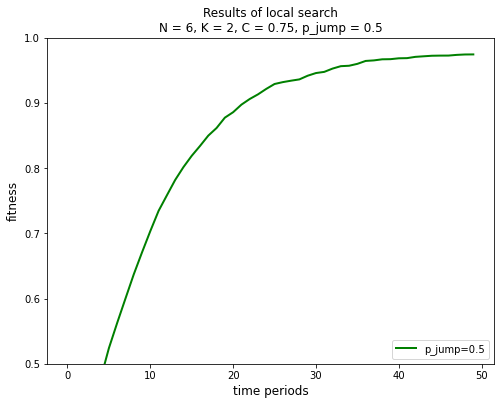

Final fitness level for long jumps: 0.9742828730197527


#######################################################




Run experiment with N = 6, K = 2, C = 0.75, p_jump = 1


Summary statistics
N = 6, K = 2, C = 0.75, p_jump = 1
average number of peaks: 2.009
maximum number of peaks: 3.0
minimum number of peaks: 2.0
average maximum value: 3.0911694127415648
average minimum value: 1.0482382969566457


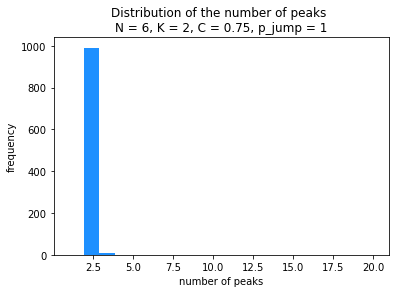

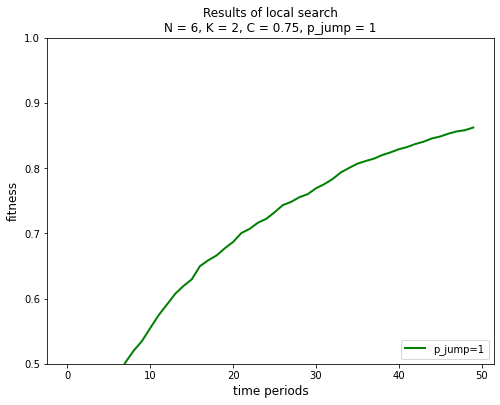

Final fitness level for long jumps: 0.8622005465608255


#######################################################




Run experiment with N = 6, K = 2, C = 1, p_jump = 0.0


Summary statistics
N = 6, K = 2, C = 1, p_jump = 0.0
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 3.9386188686343298
average minimum value: 1.293671045648986


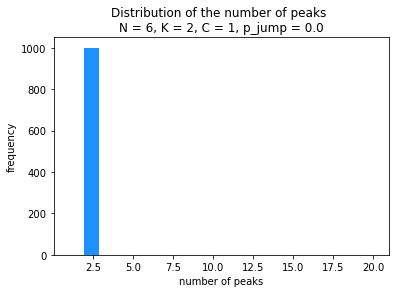

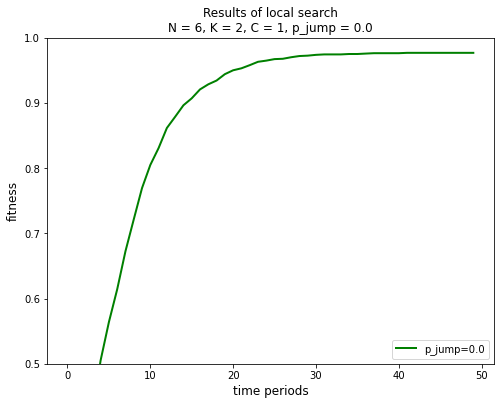

Final fitness level for long jumps: 0.9767066570828888


#######################################################




Run experiment with N = 6, K = 2, C = 1, p_jump = 0.5


Summary statistics
N = 6, K = 2, C = 1, p_jump = 0.5
average number of peaks: 2.003
maximum number of peaks: 3.0
minimum number of peaks: 2.0
average maximum value: 3.943636627914694
average minimum value: 1.298041270274728


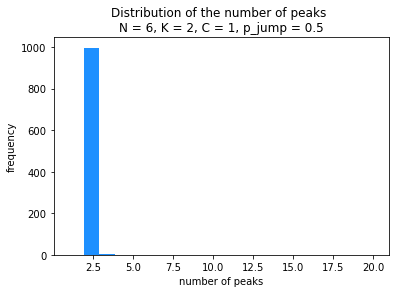

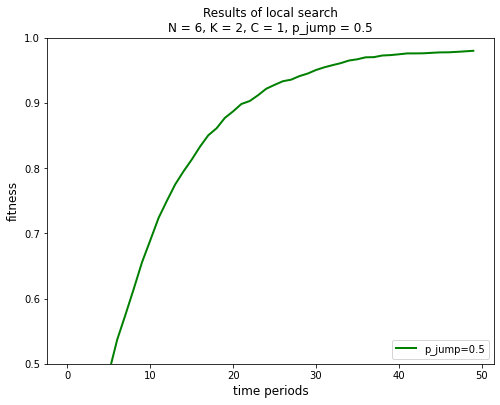

Final fitness level for long jumps: 0.9798388688092263


#######################################################




Run experiment with N = 6, K = 2, C = 1, p_jump = 1


Summary statistics
N = 6, K = 2, C = 1, p_jump = 1
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 3.9384003404766585
average minimum value: 1.2958599981896801


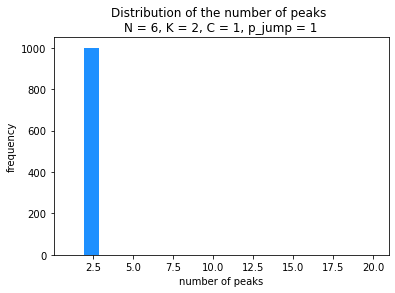

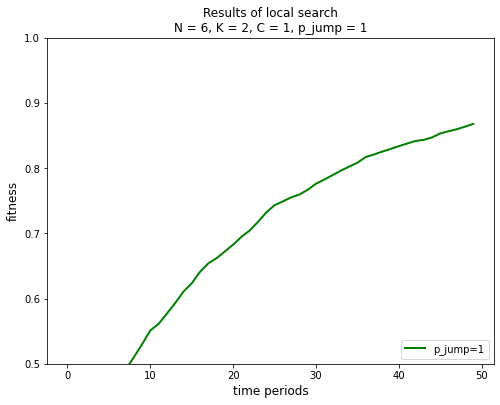

Final fitness level for long jumps: 0.8677852658992667


#######################################################




Run experiment with N = 6, K = 3, C = 0, p_jump = 0.0


Summary statistics
N = 6, K = 3, C = 0, p_jump = 0.0
average number of peaks: 5.068
maximum number of peaks: 10.0
minimum number of peaks: 2.0
average maximum value: 0.7576063029658264
average minimum value: 0.24304026169666626


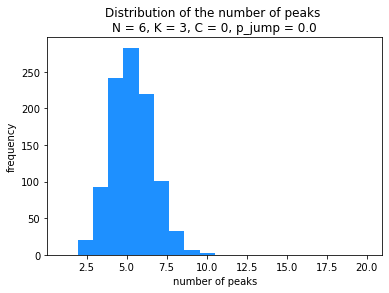

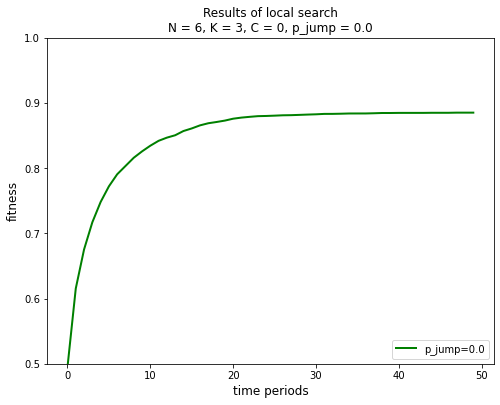

Final fitness level for long jumps: 0.8850235292934995


#######################################################




Run experiment with N = 6, K = 3, C = 0, p_jump = 0.5


Summary statistics
N = 6, K = 3, C = 0, p_jump = 0.5
average number of peaks: 4.999
maximum number of peaks: 10.0
minimum number of peaks: 2.0
average maximum value: 0.7586503183135432
average minimum value: 0.24110043003608636


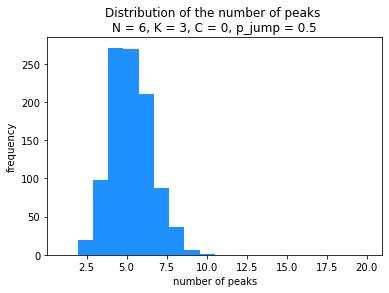

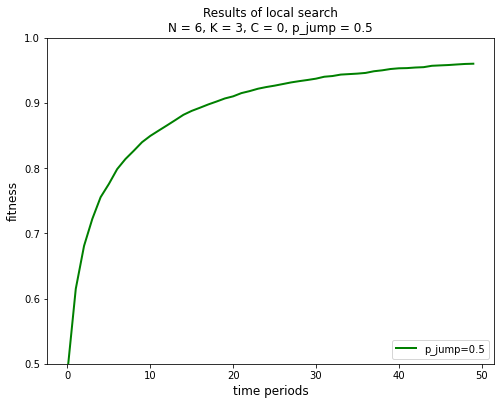

Final fitness level for long jumps: 0.9600330005339038


#######################################################




Run experiment with N = 6, K = 3, C = 0, p_jump = 1


Summary statistics
N = 6, K = 3, C = 0, p_jump = 1
average number of peaks: 5.095
maximum number of peaks: 10.0
minimum number of peaks: 1.0
average maximum value: 0.757418069616311
average minimum value: 0.2433239566875599


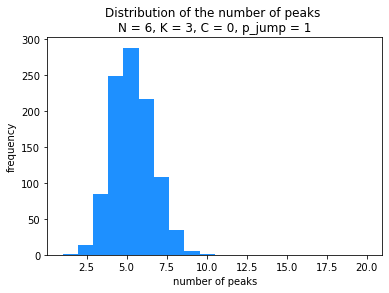

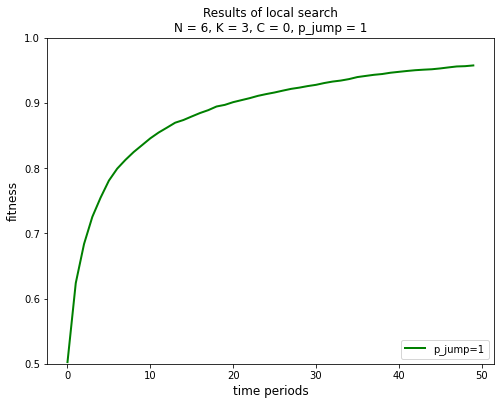

Final fitness level for long jumps: 0.9573921292738379


#######################################################




Run experiment with N = 6, K = 3, C = 0.1, p_jump = 0.0


Summary statistics
N = 6, K = 3, C = 0.1, p_jump = 0.0
average number of peaks: 4.687
maximum number of peaks: 9.0
minimum number of peaks: 1.0
average maximum value: 0.9345483176751641
average minimum value: 0.3624962744193599


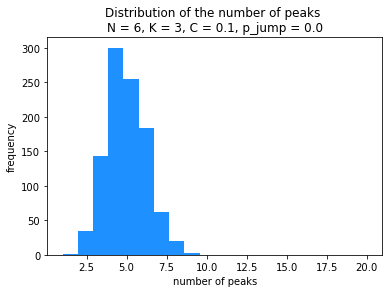

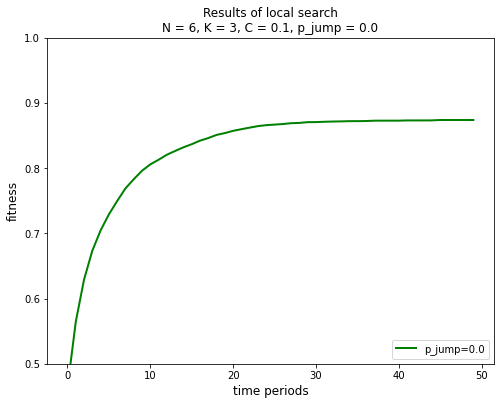

Final fitness level for long jumps: 0.8737364646385096


#######################################################




Run experiment with N = 6, K = 3, C = 0.1, p_jump = 0.5


Summary statistics
N = 6, K = 3, C = 0.1, p_jump = 0.5
average number of peaks: 4.697
maximum number of peaks: 9.0
minimum number of peaks: 1.0
average maximum value: 0.939479019888294
average minimum value: 0.3576607484673582


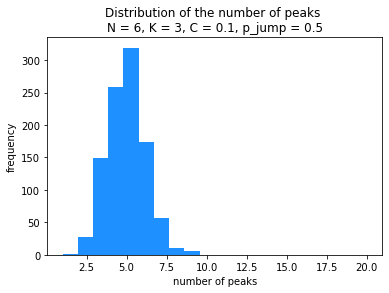

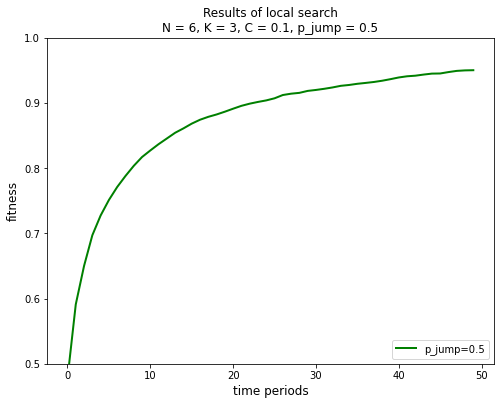

Final fitness level for long jumps: 0.9500751392470946


#######################################################




Run experiment with N = 6, K = 3, C = 0.1, p_jump = 1


Summary statistics
N = 6, K = 3, C = 0.1, p_jump = 1
average number of peaks: 4.736
maximum number of peaks: 9.0
minimum number of peaks: 1.0
average maximum value: 0.9358337050784489
average minimum value: 0.3592771368854434


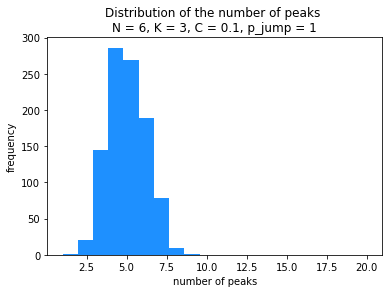

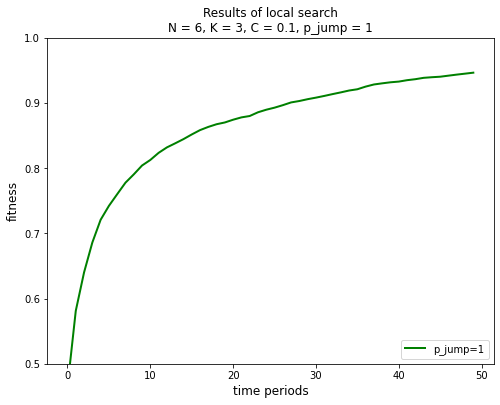

Final fitness level for long jumps: 0.9462831619442709


#######################################################




Run experiment with N = 6, K = 3, C = 0.25, p_jump = 0.0


Summary statistics
N = 6, K = 3, C = 0.25, p_jump = 0.0
average number of peaks: 3.212
maximum number of peaks: 7.0
minimum number of peaks: 2.0
average maximum value: 1.4124971832595927
average minimum value: 0.5238923328112421


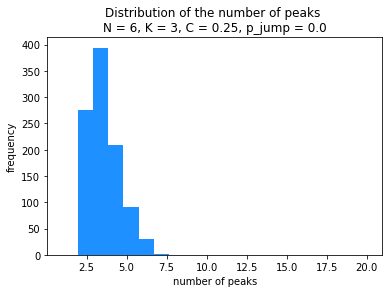

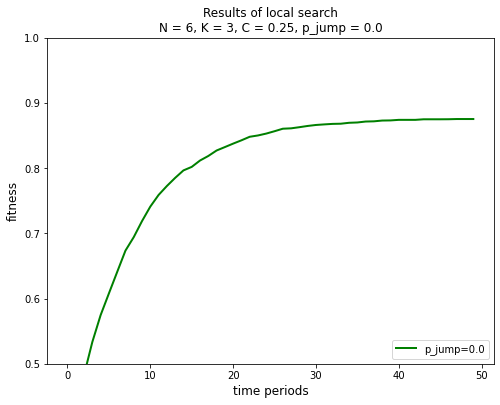

Final fitness level for long jumps: 0.8752295008508076


#######################################################




Run experiment with N = 6, K = 3, C = 0.25, p_jump = 0.5


Summary statistics
N = 6, K = 3, C = 0.25, p_jump = 0.5
average number of peaks: 3.213
maximum number of peaks: 7.0
minimum number of peaks: 2.0
average maximum value: 1.4102380236577892
average minimum value: 0.5246047734417906


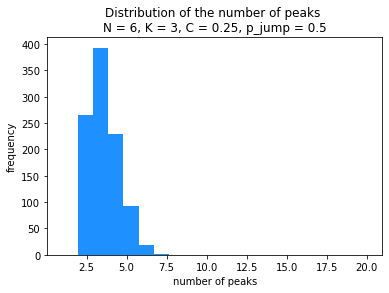

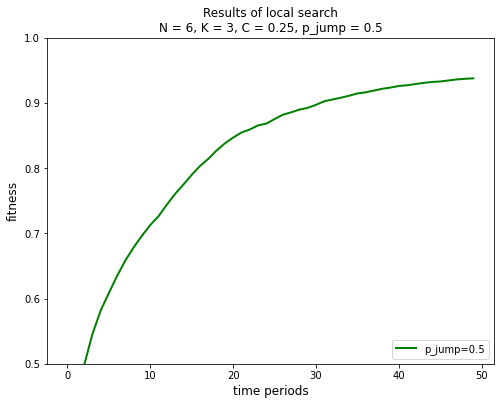

Final fitness level for long jumps: 0.9376300011331387


#######################################################




Run experiment with N = 6, K = 3, C = 0.25, p_jump = 1


Summary statistics
N = 6, K = 3, C = 0.25, p_jump = 1
average number of peaks: 3.24
maximum number of peaks: 7.0
minimum number of peaks: 2.0
average maximum value: 1.4118115510739488
average minimum value: 0.5210285084874948


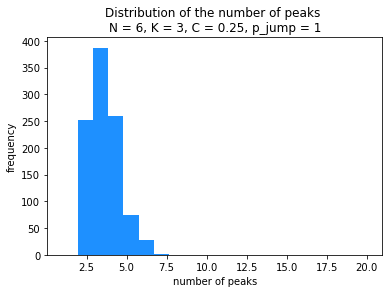

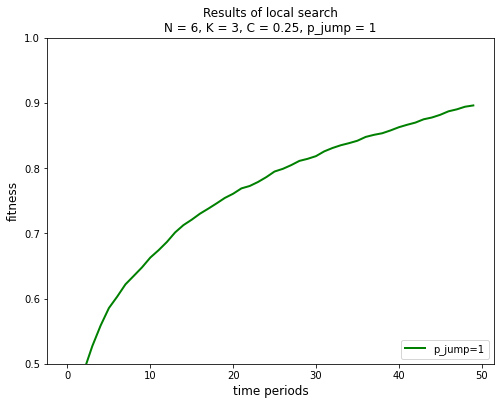

Final fitness level for long jumps: 0.896077274313932


#######################################################




Run experiment with N = 6, K = 3, C = 0.5, p_jump = 0.0


Summary statistics
N = 6, K = 3, C = 0.5, p_jump = 0.0
average number of peaks: 2.228
maximum number of peaks: 6.0
minimum number of peaks: 2.0
average maximum value: 2.2531684708370054
average minimum value: 0.782602562434763


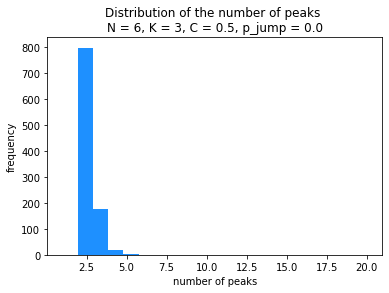

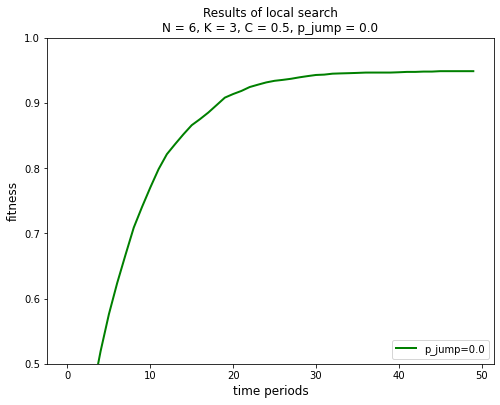

Final fitness level for long jumps: 0.948604121597059


#######################################################




Run experiment with N = 6, K = 3, C = 0.5, p_jump = 0.5


Summary statistics
N = 6, K = 3, C = 0.5, p_jump = 0.5
average number of peaks: 2.248
maximum number of peaks: 5.0
minimum number of peaks: 2.0
average maximum value: 2.252569194344454
average minimum value: 0.7827925800656347


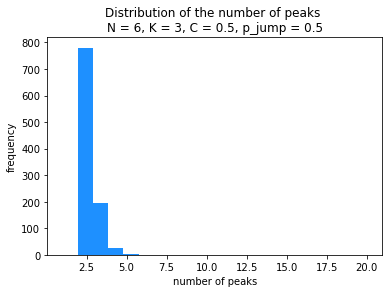

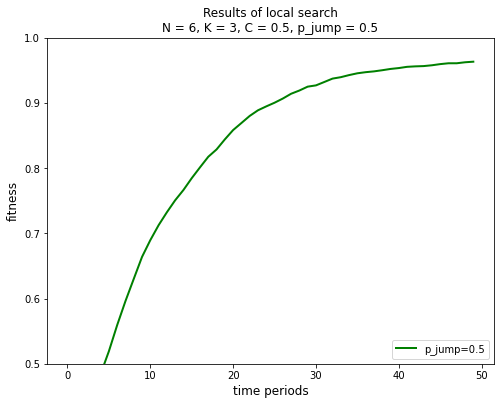

Final fitness level for long jumps: 0.9631272043010928


#######################################################




Run experiment with N = 6, K = 3, C = 0.5, p_jump = 1


Summary statistics
N = 6, K = 3, C = 0.5, p_jump = 1
average number of peaks: 2.208
maximum number of peaks: 5.0
minimum number of peaks: 2.0
average maximum value: 2.2498153331626067
average minimum value: 0.7818501466394708


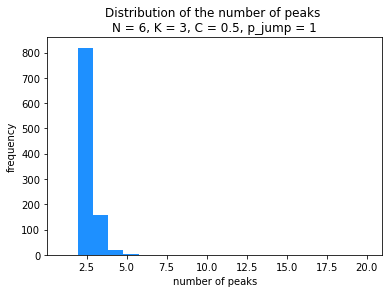

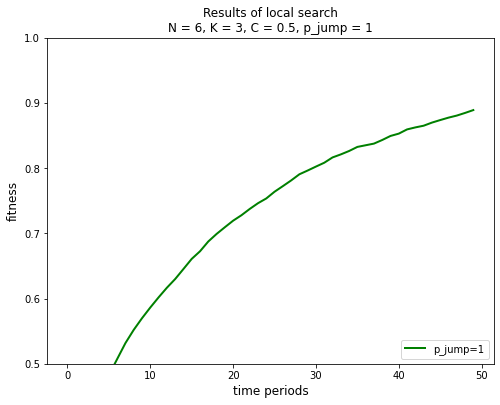

Final fitness level for long jumps: 0.8889430995676966


#######################################################




Run experiment with N = 6, K = 3, C = 0.75, p_jump = 0.0


Summary statistics
N = 6, K = 3, C = 0.75, p_jump = 0.0
average number of peaks: 2.048
maximum number of peaks: 4.0
minimum number of peaks: 2.0
average maximum value: 3.100064993695778
average minimum value: 1.0374944099680175


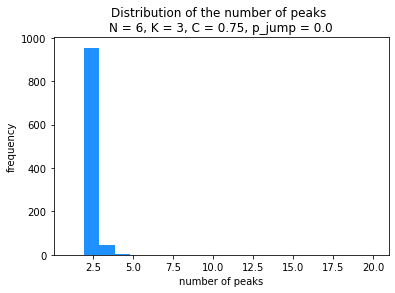

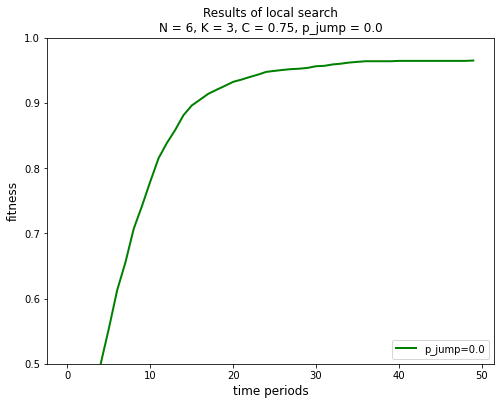

Final fitness level for long jumps: 0.9648906074640471


#######################################################




Run experiment with N = 6, K = 3, C = 0.75, p_jump = 0.5


Summary statistics
N = 6, K = 3, C = 0.75, p_jump = 0.5
average number of peaks: 2.052
maximum number of peaks: 4.0
minimum number of peaks: 2.0
average maximum value: 3.095142723481691
average minimum value: 1.0347474913030177


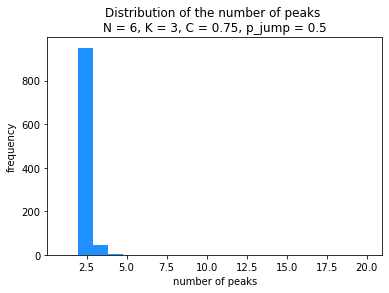

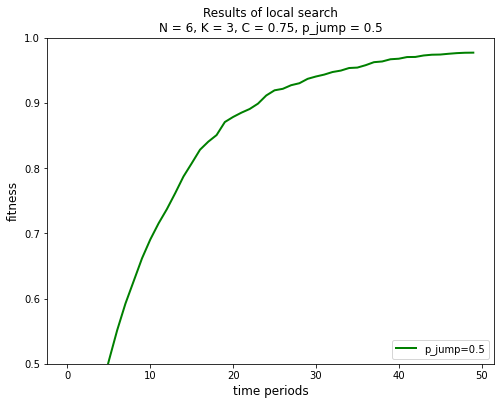

Final fitness level for long jumps: 0.9769834292620219


#######################################################




Run experiment with N = 6, K = 3, C = 0.75, p_jump = 1


Summary statistics
N = 6, K = 3, C = 0.75, p_jump = 1
average number of peaks: 2.046
maximum number of peaks: 3.0
minimum number of peaks: 2.0
average maximum value: 3.0960016364486376
average minimum value: 1.0350165272582903


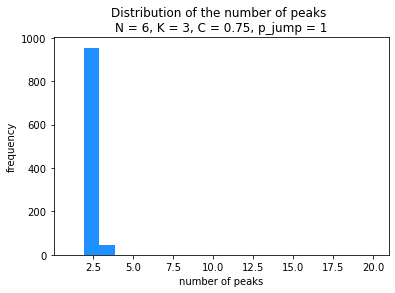

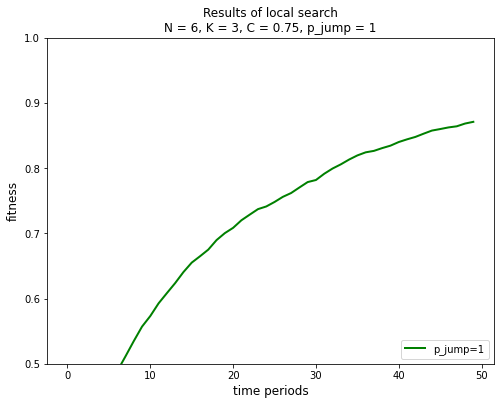

Final fitness level for long jumps: 0.8709385644017176


#######################################################




Run experiment with N = 6, K = 3, C = 1, p_jump = 0.0


Summary statistics
N = 6, K = 3, C = 1, p_jump = 0.0
average number of peaks: 2.011
maximum number of peaks: 3.0
minimum number of peaks: 2.0
average maximum value: 3.9399379590501544
average minimum value: 1.2858504208439672


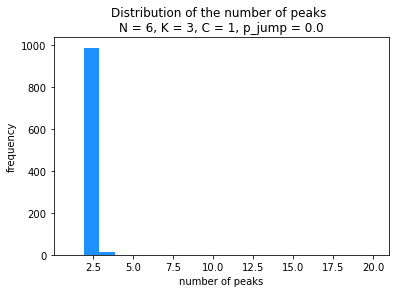

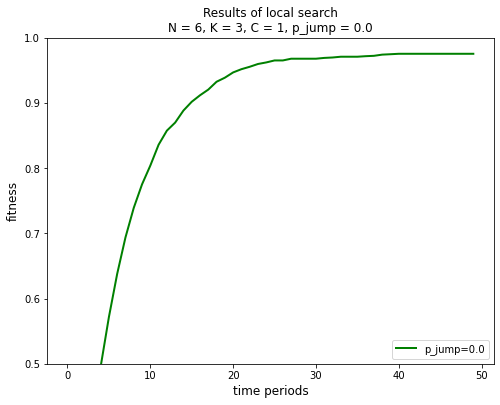

Final fitness level for long jumps: 0.9752474897119706


#######################################################




Run experiment with N = 6, K = 3, C = 1, p_jump = 0.5


Summary statistics
N = 6, K = 3, C = 1, p_jump = 0.5
average number of peaks: 2.005
maximum number of peaks: 3.0
minimum number of peaks: 2.0
average maximum value: 3.94011702808724
average minimum value: 1.2843128693340096


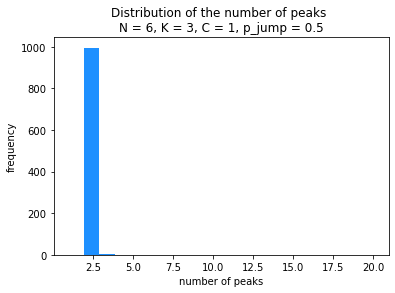

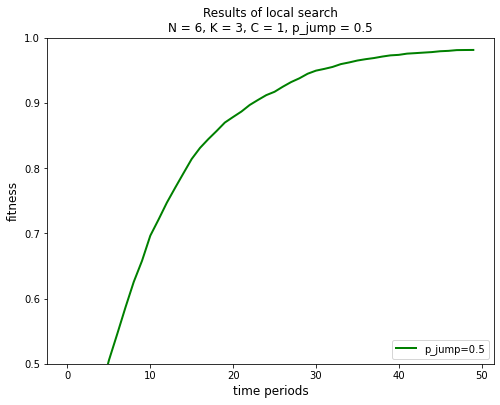

Final fitness level for long jumps: 0.9811290276838441


#######################################################




Run experiment with N = 6, K = 3, C = 1, p_jump = 1


Summary statistics
N = 6, K = 3, C = 1, p_jump = 1
average number of peaks: 2.01
maximum number of peaks: 3.0
minimum number of peaks: 2.0
average maximum value: 3.9449771581889315
average minimum value: 1.2828582311580263


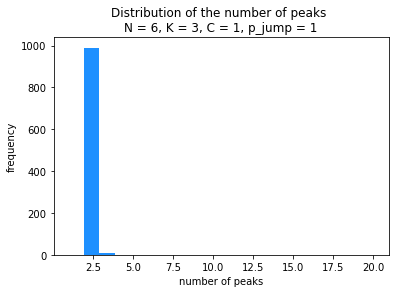

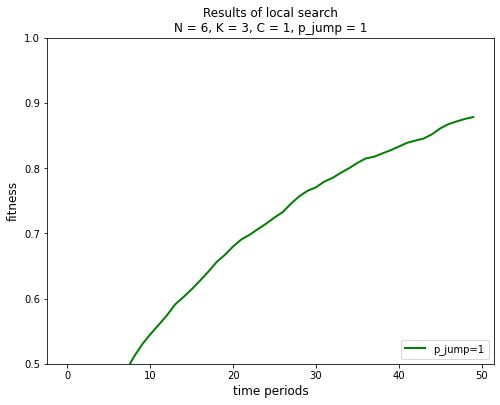

Final fitness level for long jumps: 0.8782784517067344


#######################################################




Run experiment with N = 6, K = 4, C = 0, p_jump = 0.0


Summary statistics
N = 6, K = 4, C = 0, p_jump = 0.0
average number of peaks: 6.857
maximum number of peaks: 12.0
minimum number of peaks: 2.0
average maximum value: 0.7623464521396798
average minimum value: 0.23628355341264767


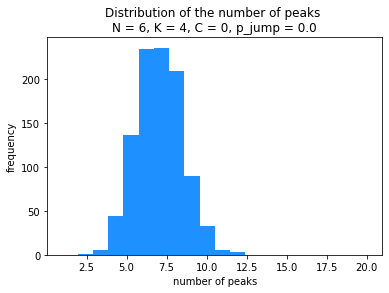

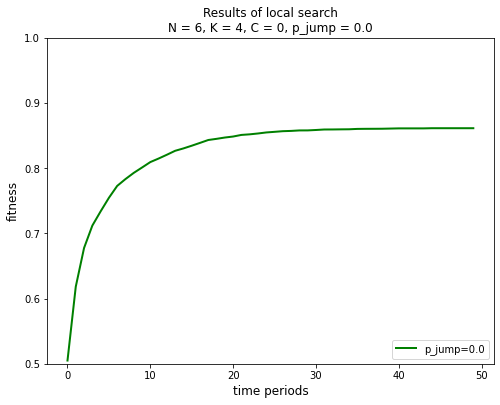

Final fitness level for long jumps: 0.8611604735653994


#######################################################




Run experiment with N = 6, K = 4, C = 0, p_jump = 0.5


Summary statistics
N = 6, K = 4, C = 0, p_jump = 0.5
average number of peaks: 7.028
maximum number of peaks: 12.0
minimum number of peaks: 3.0
average maximum value: 0.7629791709884967
average minimum value: 0.2353597739447249


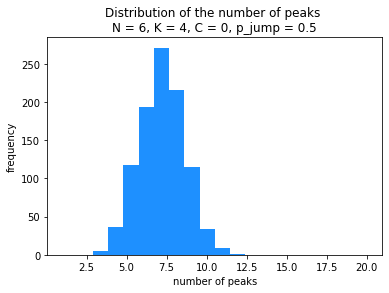

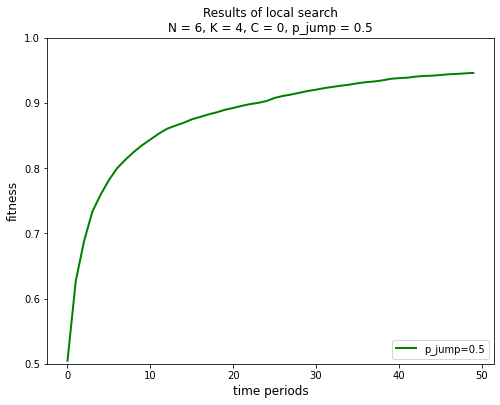

Final fitness level for long jumps: 0.9458989023651179


#######################################################




Run experiment with N = 6, K = 4, C = 0, p_jump = 1


Summary statistics
N = 6, K = 4, C = 0, p_jump = 1
average number of peaks: 7.006
maximum number of peaks: 11.0
minimum number of peaks: 2.0
average maximum value: 0.7627710372371911
average minimum value: 0.23293523375620936


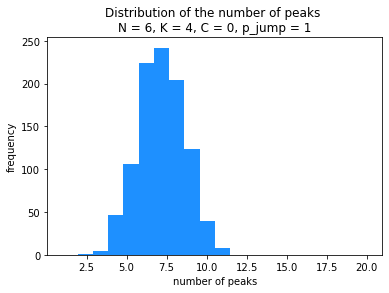

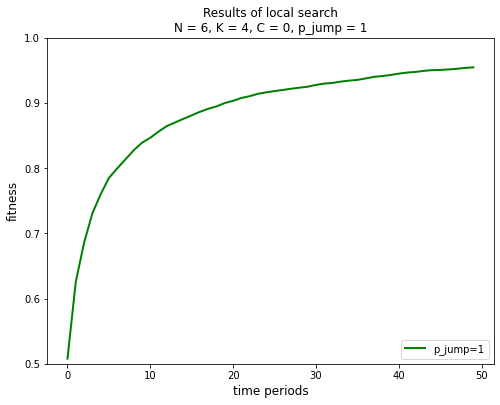

Final fitness level for long jumps: 0.954503858989681


#######################################################




Run experiment with N = 6, K = 4, C = 0.1, p_jump = 0.0


Summary statistics
N = 6, K = 4, C = 0.1, p_jump = 0.0
average number of peaks: 6.385
maximum number of peaks: 11.0
minimum number of peaks: 2.0
average maximum value: 0.9397887713982072
average minimum value: 0.35188133986703807


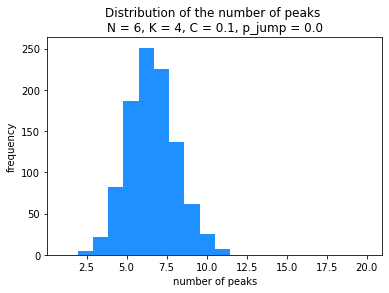

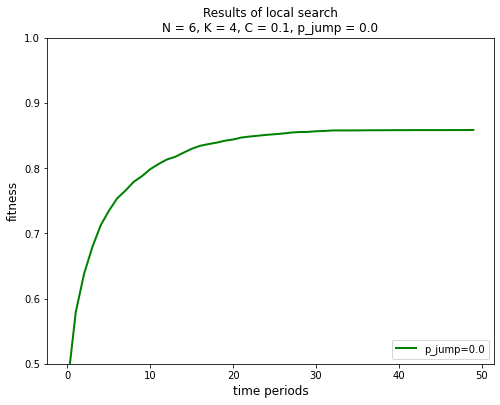

Final fitness level for long jumps: 0.858460670492657


#######################################################




Run experiment with N = 6, K = 4, C = 0.1, p_jump = 0.5


Summary statistics
N = 6, K = 4, C = 0.1, p_jump = 0.5
average number of peaks: 6.332
maximum number of peaks: 11.0
minimum number of peaks: 2.0
average maximum value: 0.9443183897167795
average minimum value: 0.35229017796359224


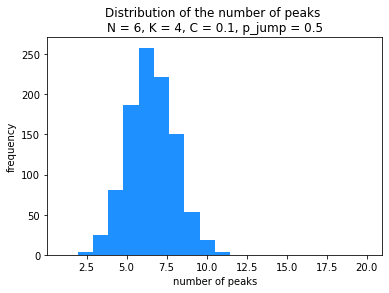

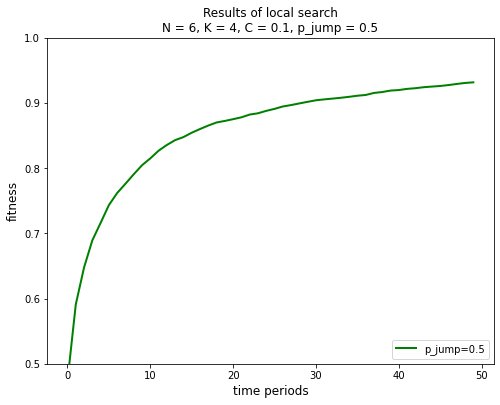

Final fitness level for long jumps: 0.931489709886799


#######################################################




Run experiment with N = 6, K = 4, C = 0.1, p_jump = 1


Summary statistics
N = 6, K = 4, C = 0.1, p_jump = 1
average number of peaks: 6.392
maximum number of peaks: 12.0
minimum number of peaks: 2.0
average maximum value: 0.9429063479108902
average minimum value: 0.3522345606407281


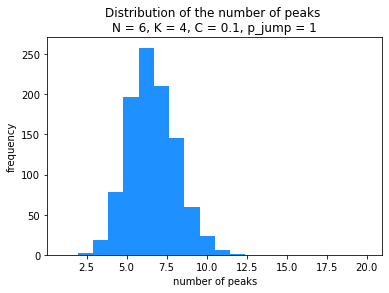

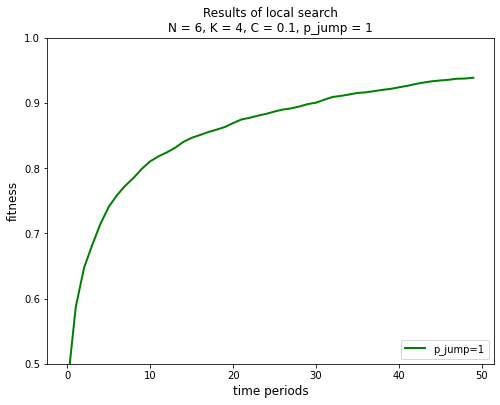

Final fitness level for long jumps: 0.938522465710637


#######################################################




Run experiment with N = 6, K = 4, C = 0.25, p_jump = 0.0


Summary statistics
N = 6, K = 4, C = 0.25, p_jump = 0.0
average number of peaks: 4.169
maximum number of peaks: 9.0
minimum number of peaks: 2.0
average maximum value: 1.4092331378164615
average minimum value: 0.5149772162352282


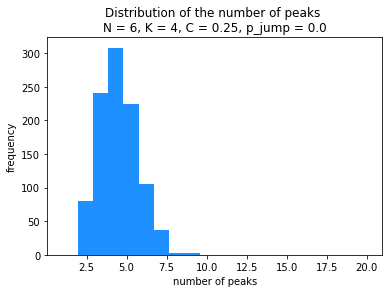

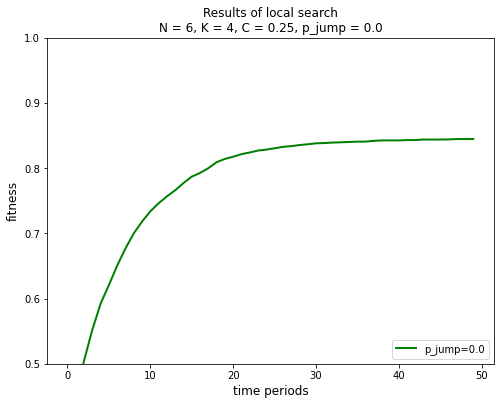

Final fitness level for long jumps: 0.8445357829167894


#######################################################




Run experiment with N = 6, K = 4, C = 0.25, p_jump = 0.5


Summary statistics
N = 6, K = 4, C = 0.25, p_jump = 0.5
average number of peaks: 4.228
maximum number of peaks: 9.0
minimum number of peaks: 2.0
average maximum value: 1.4103967903080692
average minimum value: 0.5161771724775821


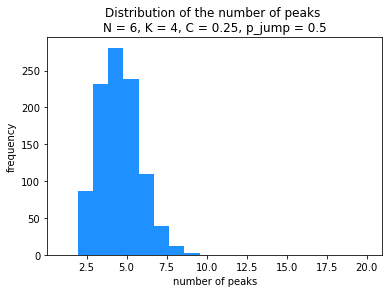

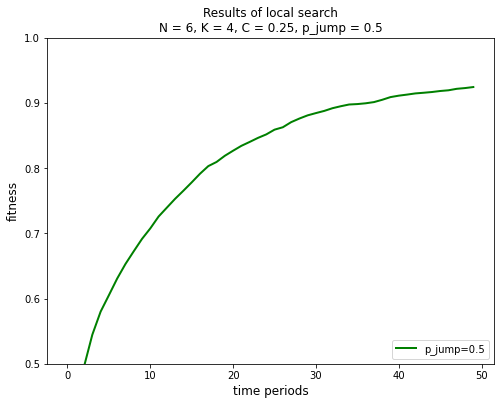

Final fitness level for long jumps: 0.924264831147907


#######################################################




Run experiment with N = 6, K = 4, C = 0.25, p_jump = 1


Summary statistics
N = 6, K = 4, C = 0.25, p_jump = 1
average number of peaks: 4.204
maximum number of peaks: 8.0
minimum number of peaks: 2.0
average maximum value: 1.4071046858815435
average minimum value: 0.5165833667964449


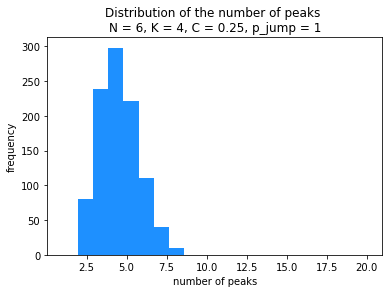

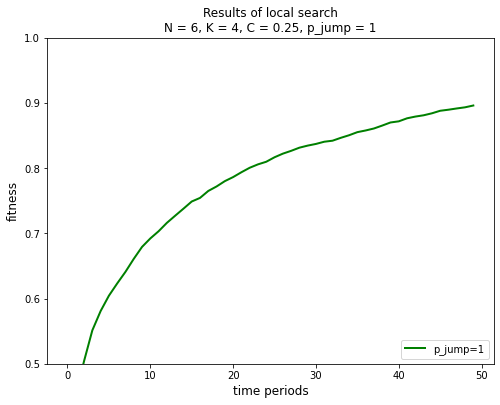

Final fitness level for long jumps: 0.8959640813860033


#######################################################




Run experiment with N = 6, K = 4, C = 0.5, p_jump = 0.0


Summary statistics
N = 6, K = 4, C = 0.5, p_jump = 0.0
average number of peaks: 2.563
maximum number of peaks: 6.0
minimum number of peaks: 2.0
average maximum value: 2.249208375601947
average minimum value: 0.7737322154311195


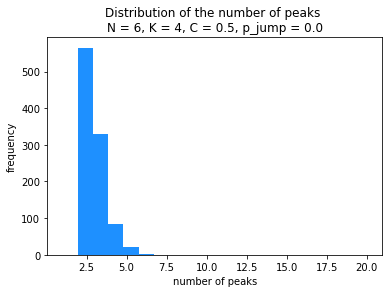

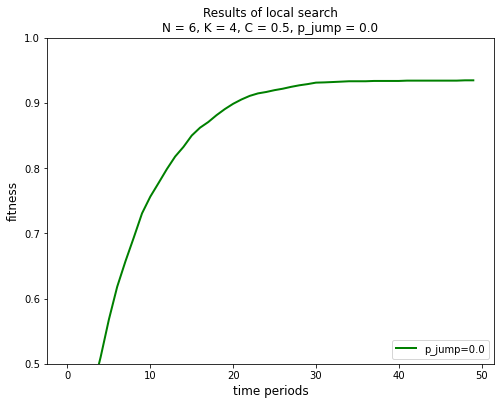

Final fitness level for long jumps: 0.9345647802343711


#######################################################




Run experiment with N = 6, K = 4, C = 0.5, p_jump = 0.5




In [ ]:
for N in Ns:
    for K in Ks:
        for C in Cs:
            for p_jump in p_jumps:
                result = run_experiment(N=N, K=K, C=C, p_jump=p_jump)
                results.append(result)

In [ ]:
df = pd.DataFrame(results)
df.to_csv("./results.csv", 
              header=True, 
              index=False, 
              quoting=csv.QUOTE_ALL
    )

In [ ]:
print("Done")